In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/web-traffic-time-series-forecasting/sample_submission_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/sample_submission_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip


> Task summary - 

To forecast future web traffic as time series for approximately 145,000 wikipedia articles.

> Concepts

- Univariate models are statistical analysis approaches that involve the analysis of a single dependent variable. Only one variable varies over time. For ex- Sensor measuring temperature of a room per second.

- Multi variate analysis examines two or more dependent variables and multiple independent variables. Multiple variables are varying over time

- Time series is a data that occurs chronologically one after the other.
- Time series forecasting is using the data of the past to detect the future.
- Forecasting values in dynamic system(i.e source of values is dynamic) is hard.
- Every being, global event, their lives are dynamic system for the web traffic. For example - Whenever a semester starts in a university then that corresponding major's wikipedia may be getting a hit to know more about it.

- We usually tend to remove anomaly from time series dataset i.e abnormal behaviour.

> Steps

1. Data cleaning.
2. Visualisation.
3. Remove anomalies.
4. Apply ARMA Model.
5. Apply ARIMA Model.
6. Apply Exponential Smoothing Model.
7. Apply Prophet approach(fbprophet, future)
8. Apply Auto Arima.
9. Apply DL Model(LSTM).
10. Apply DL model(CNN1D).

In [5]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
from datetime import timedelta
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#from fbprophet import Prophet
!pip install pmdarima
from pmdarima import auto_arima

from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow import keras

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import r2_score
import re

  Using cached pmdarima-2.0.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.8 MB)


In [6]:
!unzip /kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip


Archive:  /kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip
  inflating: train_1.csv             


In [7]:
!ls

__notebook_source__.ipynb  train_1.csv


In [8]:
data_path = "train_1.csv"


In [9]:
df = pd.read_csv(data_path)
df.head()
# these are page views per days spread across various columns

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


## 1. Data Cleaning

In [10]:
# Fill missing values
df = df.fillna(0)

In [11]:
# sept to dec data
train_data = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Visits')
train_data.head()

,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [12]:
train_data['Date'] = pd.DatetimeIndex(train_data['Date'])
train_data

,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0
...,...,...,...
79784645,Underworld_(serie_de_películas)_es.wikipedia.o...,2016-12-31,10.0
79784646,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,2016-12-31,0.0
79784647,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,2016-12-31,0.0
79784648,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,2016-12-31,0.0


## 2. Data Visualization

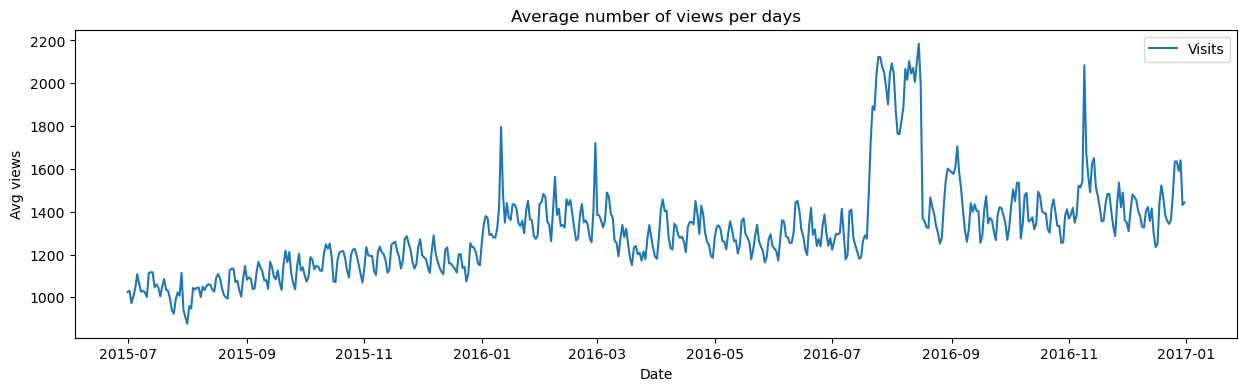

In [13]:
#visualising
temp = train_data.groupby('Date')['Visits'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.title('Average number of views per days')
plt.plot(temp,label='Visits')
plt.legend()
plt.show()

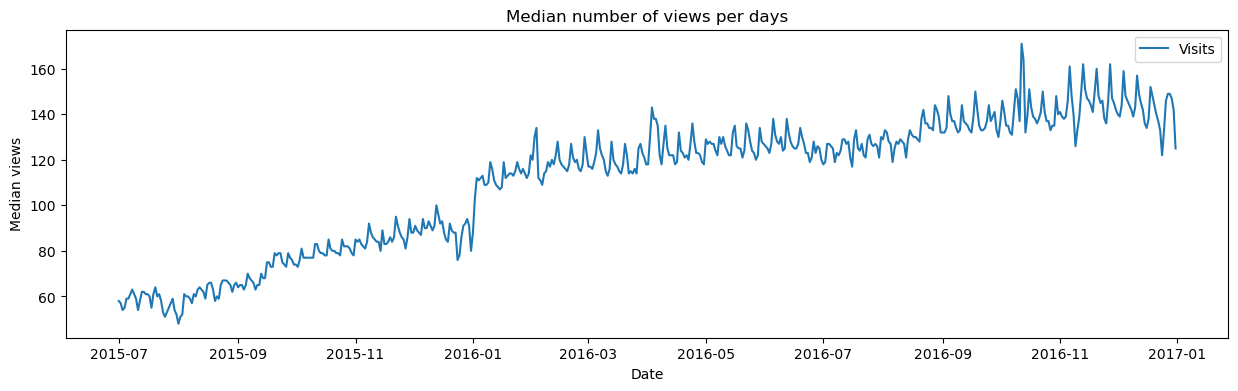

In [14]:
#visualising
temp = train_data.groupby('Date')['Visits'].median()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Median views')
plt.title('Median number of views per days')
plt.plot(temp,label='Visits')
plt.legend()
plt.show()

In [15]:
train_data

,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0
...,...,...,...
79784645,Underworld_(serie_de_películas)_es.wikipedia.o...,2016-12-31,10.0
79784646,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,2016-12-31,0.0
79784647,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,2016-12-31,0.0
79784648,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,2016-12-31,0.0


In [16]:
train_data['year']=train_data.Date.dt.year 
train_data['month']=train_data.Date.dt.month 
train_data['day']=train_data.Date.dt.day

In [17]:
#plotting web traffic over days of month using heatmap
# data is of 9th month to 12th
train_data['month_num'] = train_data['month']
train_data['month'].replace('9','9 - September',inplace=True)
train_data['month'].replace('10','10 - October',inplace=True)
train_data['month'].replace('11','11 - November',inplace=True)
train_data['month'].replace('12','12 - December',inplace=True)

In [18]:
train_data


,Page,Date,Visits,year,month,day,month_num
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,2015,7,1,7
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0,2015,7,1,7
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0,2015,7,1,7
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0,2015,7,1,7
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0,2015,7,1,7
...,...,...,...,...,...,...,...
79784645,Underworld_(serie_de_películas)_es.wikipedia.o...,2016-12-31,10.0,2016,12,31,12
79784646,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,2016-12-31,0.0,2016,12,31,12
79784647,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,2016-12-31,0.0,2016,12,31,12
79784648,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,2016-12-31,0.0,2016,12,31,12


In [19]:
train_data['weekday'] = train_data['Date'].apply(lambda x: x.weekday())


In [20]:
train_data['weekday#'] = train_data['weekday']
train_data['weekday'].replace(0,'01 - Monday',inplace=True)
train_data['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_data['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_data['weekday'].replace(3,'04 - Thursday',inplace=True)
train_data['weekday'].replace(4,'05 - Friday',inplace=True)
train_data['weekday'].replace(5,'06 - Saturday',inplace=True)
train_data['weekday'].replace(6,'07 - Sunday',inplace=True)

In [21]:
train_data


,Page,Date,Visits,year,month,day,month_num,weekday,weekday#
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,2015,7,1,7,03 - Wednesday,2
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0,2015,7,1,7,03 - Wednesday,2
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0,2015,7,1,7,03 - Wednesday,2
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0,2015,7,1,7,03 - Wednesday,2
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0,2015,7,1,7,03 - Wednesday,2
...,...,...,...,...,...,...,...,...,...
79784645,Underworld_(serie_de_películas)_es.wikipedia.o...,2016-12-31,10.0,2016,12,31,12,06 - Saturday,5
79784646,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,2016-12-31,0.0,2016,12,31,12,06 - Saturday,5
79784647,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,2016-12-31,0.0,2016,12,31,12,06 - Saturday,5
79784648,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,2016-12-31,0.0,2016,12,31,12,06 - Saturday,5


In [22]:
train_group = train_data.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group = train_group.pivot('weekday','month','Visits')
train_group.sort_index(inplace=True)

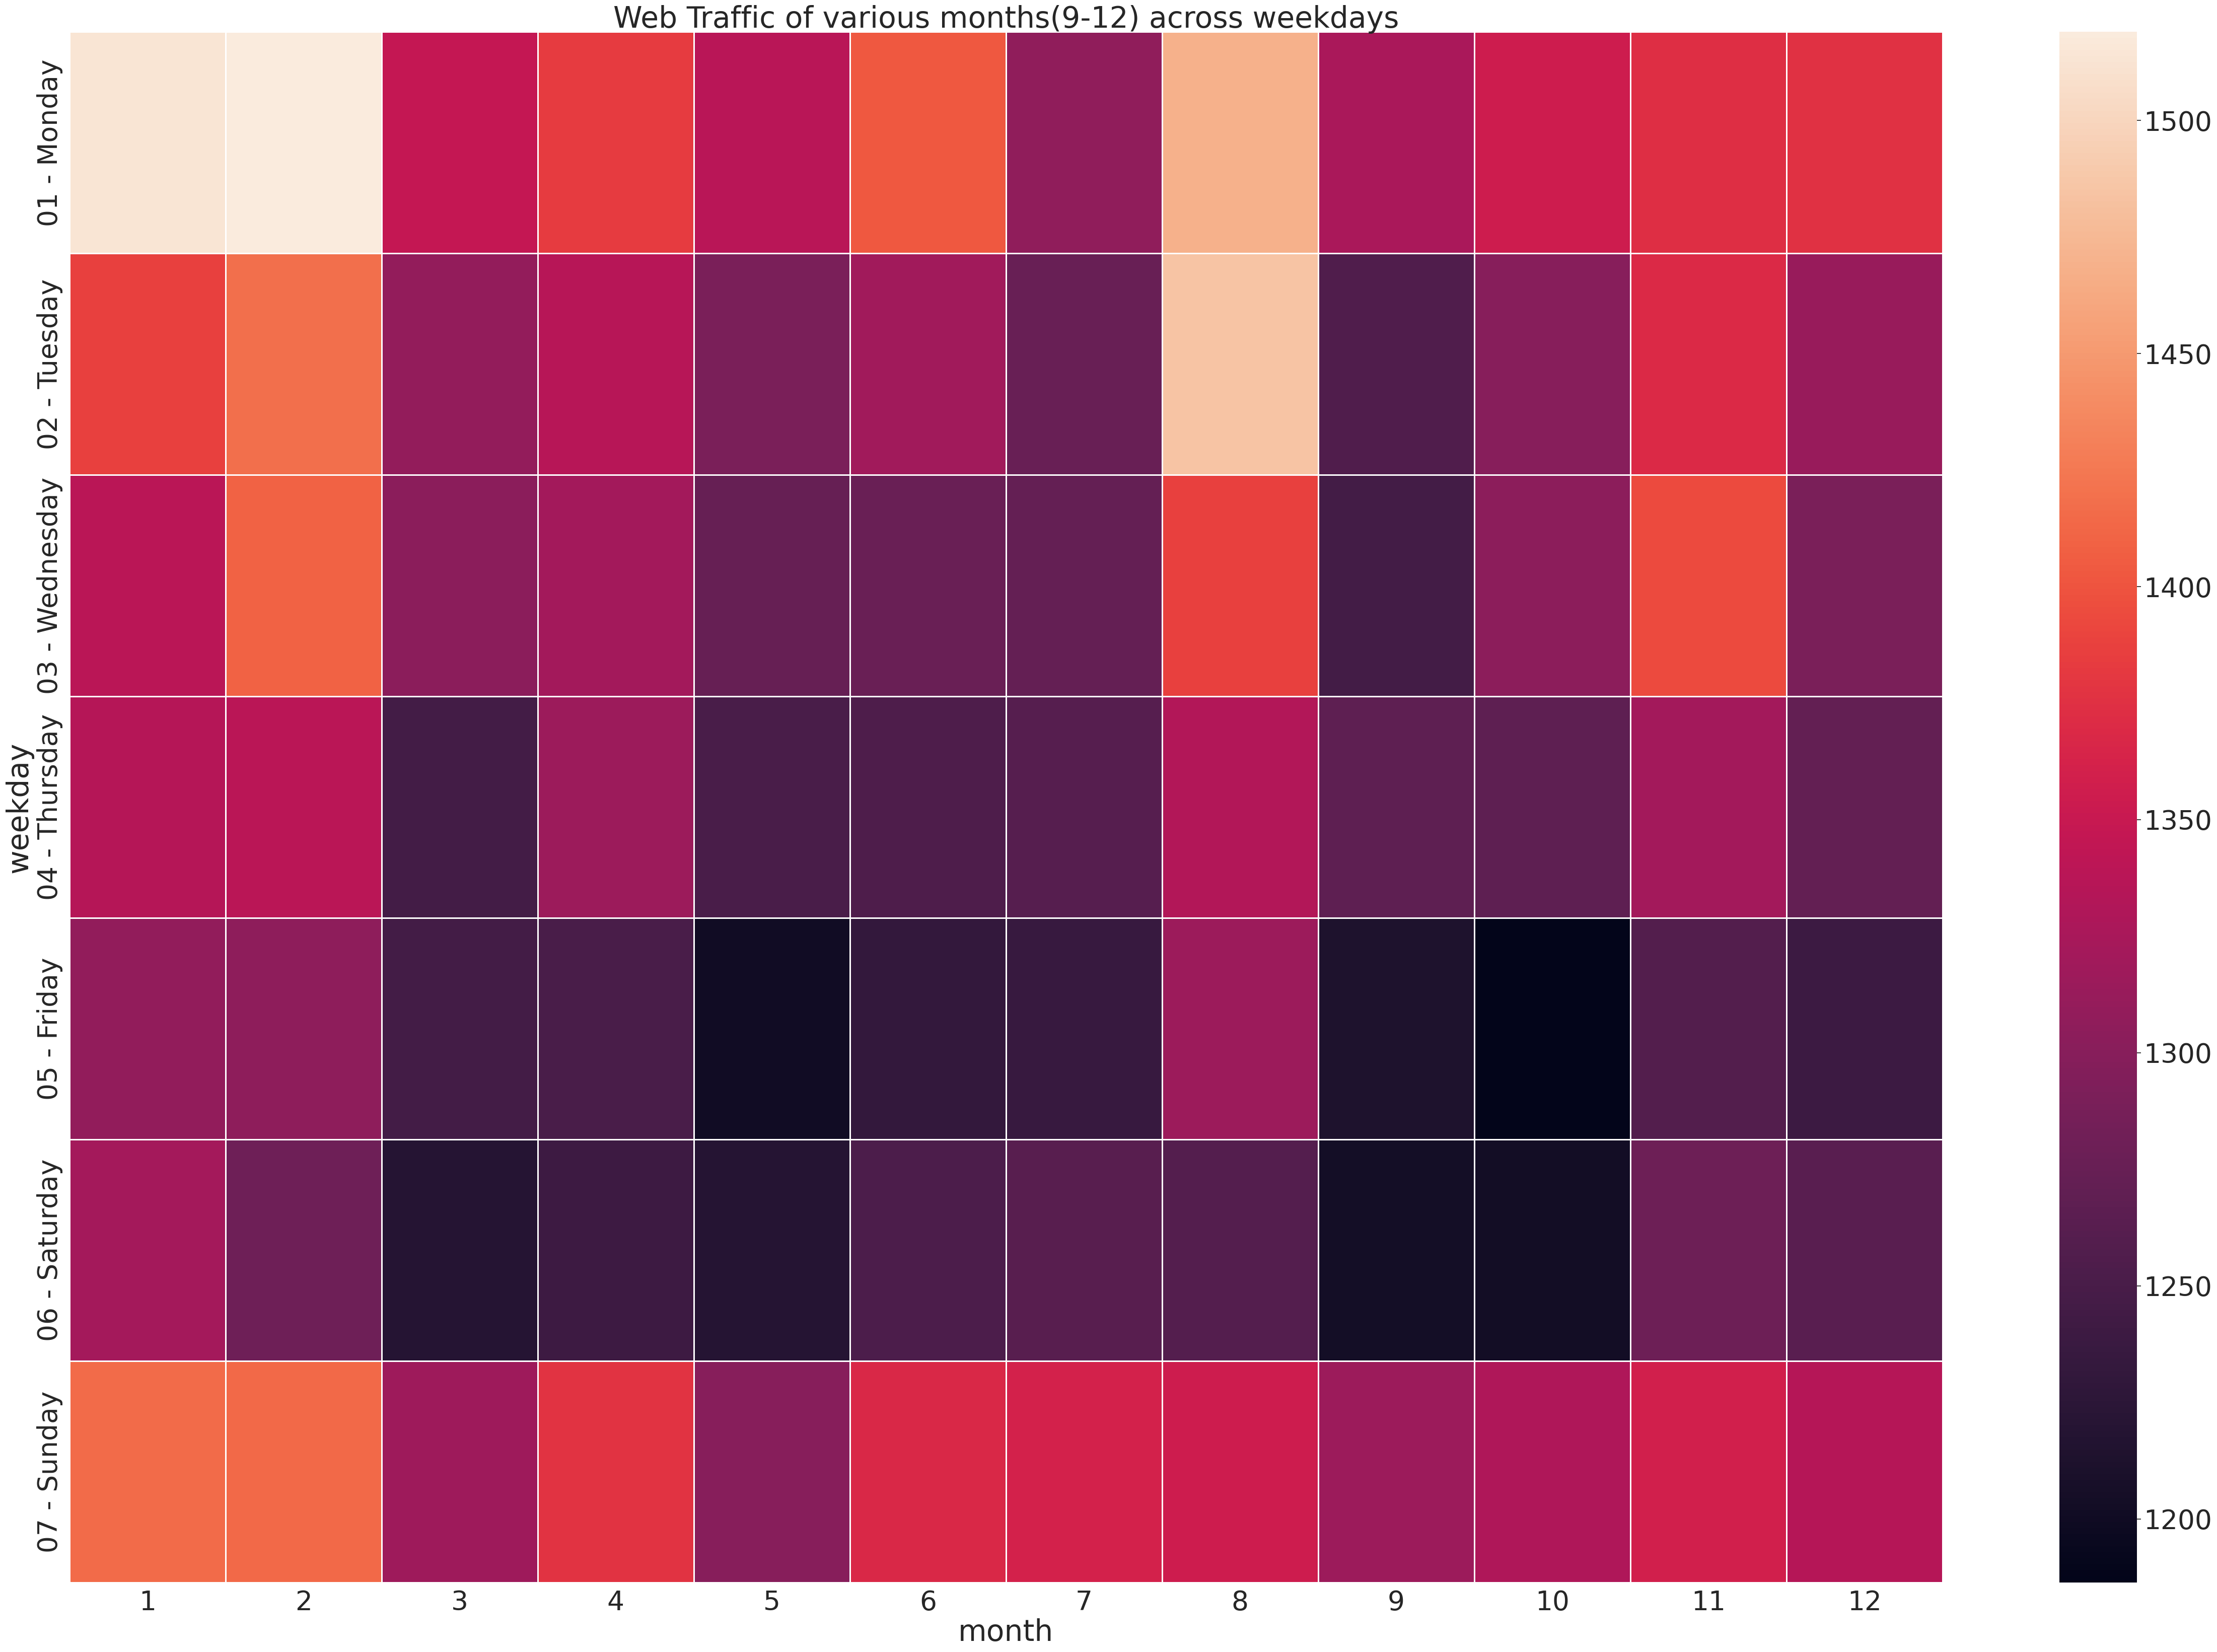

In [23]:
sns.set(font_scale=3.5) 
f, ax = plt.subplots(figsize=(60, 40))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic of various months(9-12) across weekdays')
plt.show()

We can see that the traffic is maximum on fridays and saturdays on most of the months during the span of Sept to Dec.



In [24]:
cols_to_drop = ['year','month','day','month_num','weekday','weekday','weekday#']
train_data.drop(cols_to_drop,axis=1,inplace=True)
train_data


,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0
...,...,...,...
79784645,Underworld_(serie_de_películas)_es.wikipedia.o...,2016-12-31,10.0
79784646,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,2016-12-31,0.0
79784647,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,2016-12-31,0.0
79784648,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,2016-12-31,0.0


In [25]:
# top 5 pages with maximum number of views
top_pages = train_data.groupby('Page')['Visits'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Visits')['Page'].tolist()

In [26]:
top5_pages_df = train_data[train_data['Page'].isin(top_pages_list)]
top5_pages_df

,Page,Date,Visits
9774,Main_Page_en.wikipedia.org_desktop_all-agents,2015-07-01,11952559.0
38573,Main_Page_en.wikipedia.org_all-access_all-agents,2015-07-01,20381245.0
39180,Special:Search_en.wikipedia.org_all-access_all...,2015-07-01,2034850.0
74114,Main_Page_en.wikipedia.org_mobile-web_all-agents,2015-07-01,8039732.0
139119,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2015-07-01,2983623.0
...,...,...,...
79649361,Main_Page_en.wikipedia.org_desktop_all-agents,2016-12-31,19591761.0
79678160,Main_Page_en.wikipedia.org_all-access_all-agents,2016-12-31,26149541.0
79678767,Special:Search_en.wikipedia.org_all-access_all...,2016-12-31,1576945.0
79713701,Main_Page_en.wikipedia.org_mobile-web_all-agents,2016-12-31,3939419.0


In [27]:
#detecting language across page
def detect_language(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'

In [28]:
temp1 = train_data
temp1['Wikipedia_page'] = temp1.Page.apply(detect_language)

In [29]:
def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'

In [30]:
temp1['Page_language'] = temp1.Wikipedia_page.apply(lang_code)


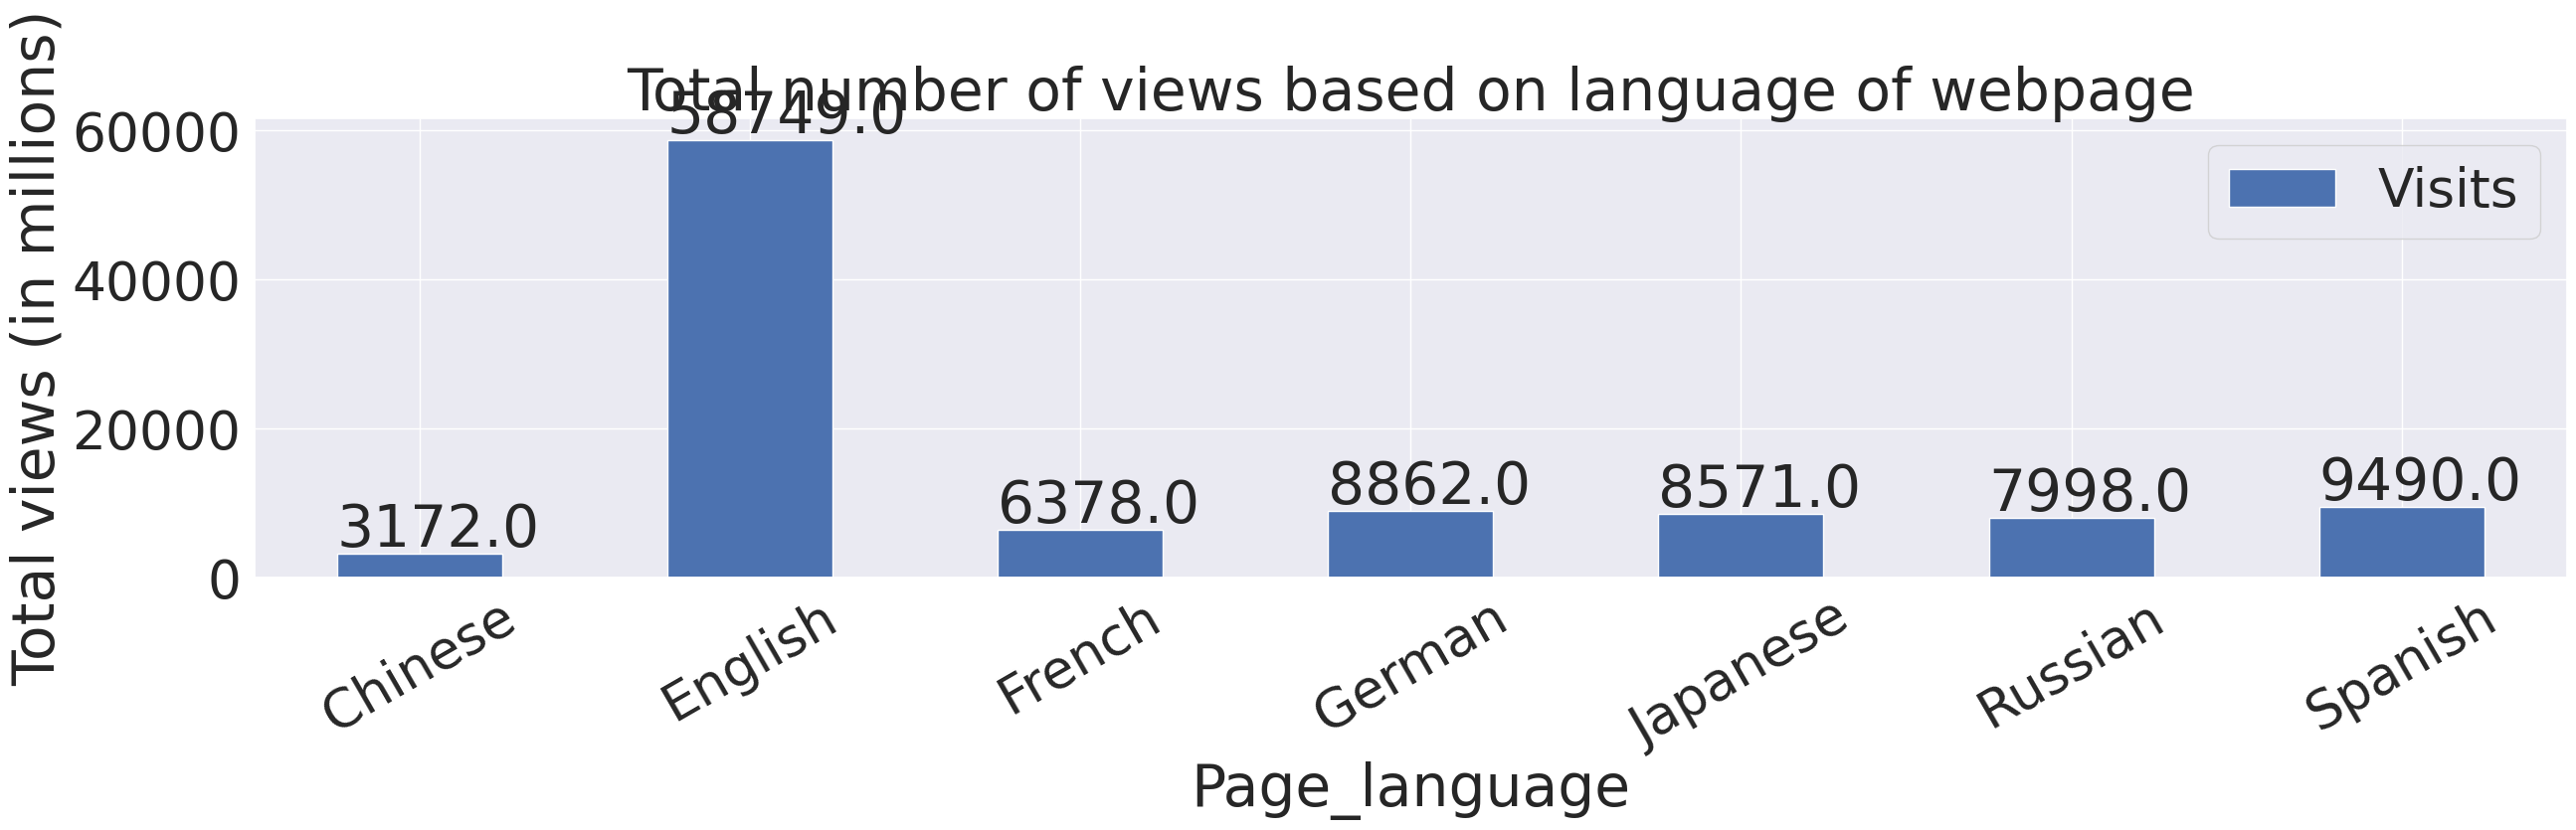

In [31]:
# Total number of views based on language of Wikipedia webpage
fig,ax = plt.subplots(figsize=(30,6))
lang_df = temp1.groupby('Page_language')['Visits'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Visits'] = round(lang_df['Visits']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Visits',rot=30,ax=ax)
bar_graph.set_ylabel('Total views (in millions)')
bar_graph.set_title('Total number of views based on language of webpage')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()+1000))
ax.legend()
plt.show()

In [32]:
top_pages = train_data.groupby('Page')['Visits'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Visits')['Page'].tolist()
print(top_pages_list)

['Main_Page_en.wikipedia.org_all-access_all-agents', 'Main_Page_en.wikipedia.org_desktop_all-agents', 'Main_Page_en.wikipedia.org_mobile-web_all-agents', 'Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents', 'Special:Search_en.wikipedia.org_all-access_all-agents']


In [33]:
top5_pages_df = train_data[train_data['Page'].isin(top_pages_list)]


In [34]:
top5_pages_df


,Page,Date,Visits,Wikipedia_page,Page_language
9774,Main_Page_en.wikipedia.org_desktop_all-agents,2015-07-01,11952559.0,en,English
38573,Main_Page_en.wikipedia.org_all-access_all-agents,2015-07-01,20381245.0,en,English
39180,Special:Search_en.wikipedia.org_all-access_all...,2015-07-01,2034850.0,en,English
74114,Main_Page_en.wikipedia.org_mobile-web_all-agents,2015-07-01,8039732.0,en,English
139119,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2015-07-01,2983623.0,de,German
...,...,...,...,...,...
79649361,Main_Page_en.wikipedia.org_desktop_all-agents,2016-12-31,19591761.0,en,English
79678160,Main_Page_en.wikipedia.org_all-access_all-agents,2016-12-31,26149541.0,en,English
79678767,Special:Search_en.wikipedia.org_all-access_all...,2016-12-31,1576945.0,en,English
79713701,Main_Page_en.wikipedia.org_mobile-web_all-agents,2016-12-31,3939419.0,en,English


In [35]:
# Time-series of page with maximum views
top_page_df = train_data[train_data.Page == top_pages_list[0]]
#top_page_df = top_page_df['Visits']
top_page_df['Visits'] = top_page_df['Visits'].div(1000000).round(2)
top_page_df.drop(['Page','Wikipedia_page','Page_language'],axis=1,inplace=True)
top_page_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Date,Visits
38573,2015-07-01,20.38
183636,2015-07-02,20.75
328699,2015-07-03,19.57
473762,2015-07-04,20.44
618825,2015-07-05,20.77


In [36]:
top_page_df.reset_index(inplace=True)


In [37]:
top_page_df.head()


,index,Date,Visits
0,38573,2015-07-01,20.38
1,183636,2015-07-02,20.75
2,328699,2015-07-03,19.57
3,473762,2015-07-04,20.44
4,618825,2015-07-05,20.77


In [38]:
top_page_df.drop('index',axis=1,inplace=True)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
top_page_df = top_page_df.set_index('Date')
top_page_df.head()

,Visits
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77


<AxesSubplot:xlabel='Date'>

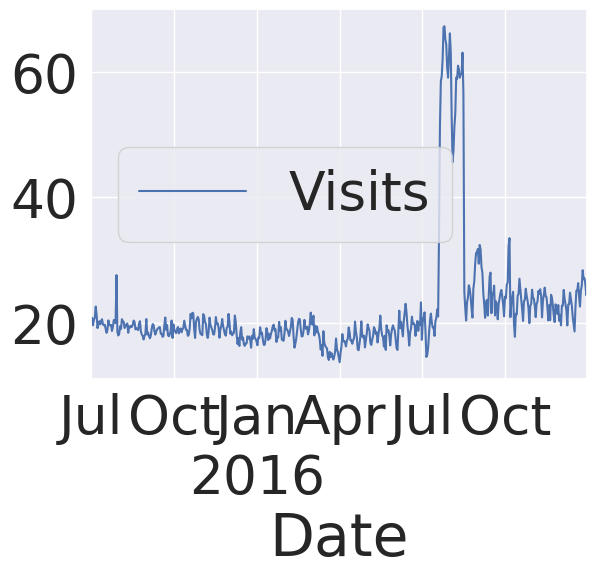

In [40]:
top_page_df.plot()


## 3. Anomaly Detection
Using isolation forest since as seen in the figure above, There are anomalies in the data. Using data with anomalies for forecasting will affect the accuracy of the model. Hence anomalies are removed using Isolation forest.

In [41]:
isolation_forest_model = IsolationForest(contamination=0.05)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


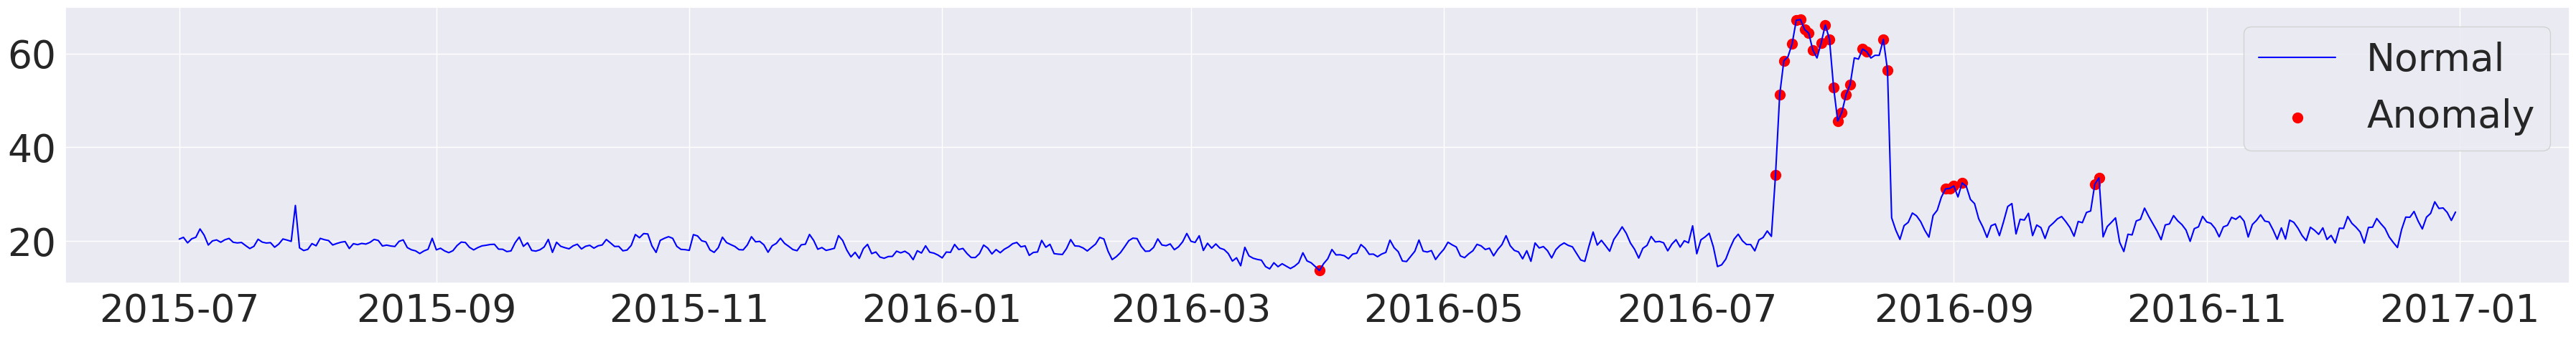

In [42]:
fig, ax = plt.subplots(figsize=(45,5))
anomaly_df = top_page_df.loc[top_page_df['anomaly'] == -1].copy()
ax.plot(top_page_df.index,top_page_df['Visits'],color='blue', label = 'Normal')
plt.scatter(anomaly_df.index,anomaly_df['Visits'],color='red',s=100,label = 'Anomaly')
plt.legend()
plt.show()

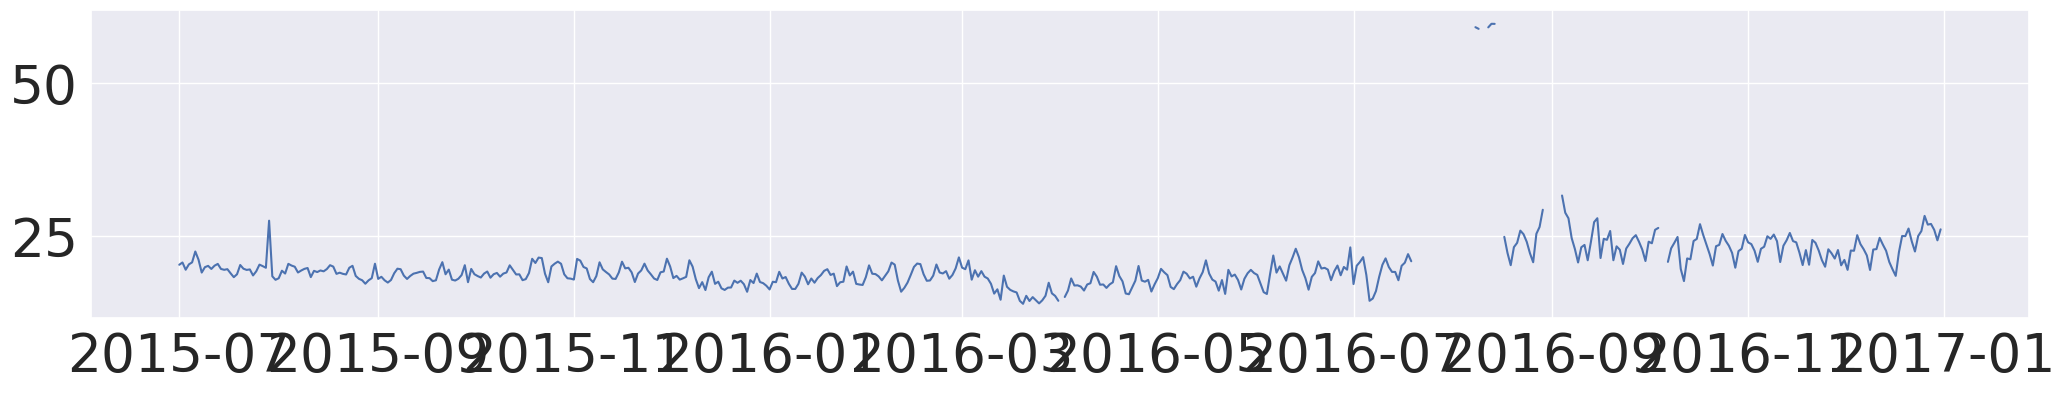

In [43]:
# Removing anomalies from the data
top_page_df['new_visits'] = top_page_df.apply(lambda row: row.Visits if row.anomaly == 1 else None, axis='columns')
plt.figure(figsize=(25,4))
plt.plot(top_page_df.index,top_page_df.new_visits)

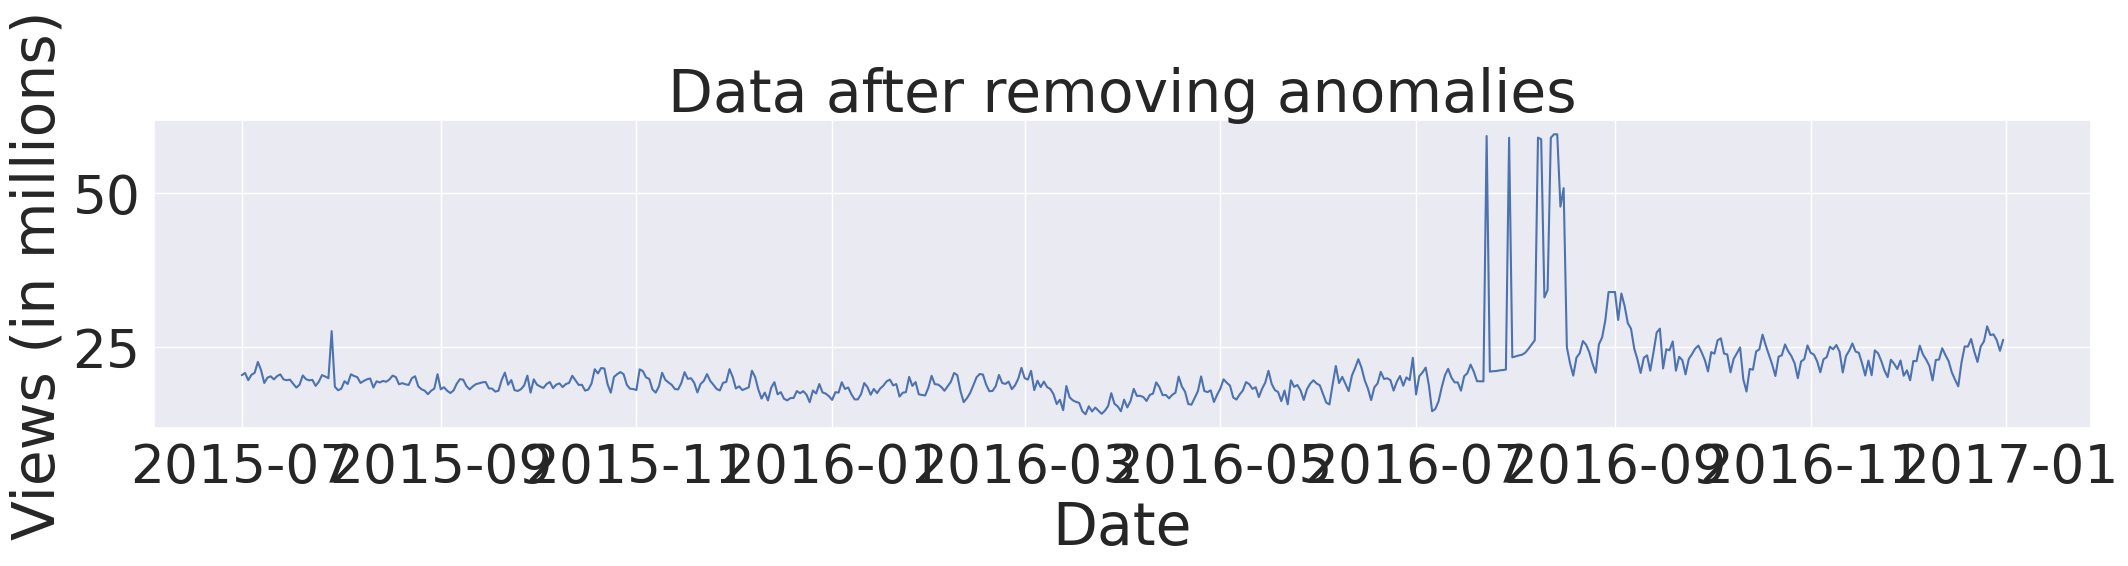

In [44]:
# Filling missing data with rolling mean
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_visits.fillna(top_page_df.new_visits.rolling(30,min_periods=1).mean()))

plt.figure(figsize=(25,4))
plt.plot(top_page_df.index,top_page_df.rolling_mean)
plt.title('Data after removing anomalies')
plt.xlabel('Date')
plt.ylabel('Views (in millions)')
plt.show()

In [45]:
top_page_df = top_page_df.drop(columns=['Visits','anomaly','new_visits']).rename(columns={'rolling_mean':'Views'})


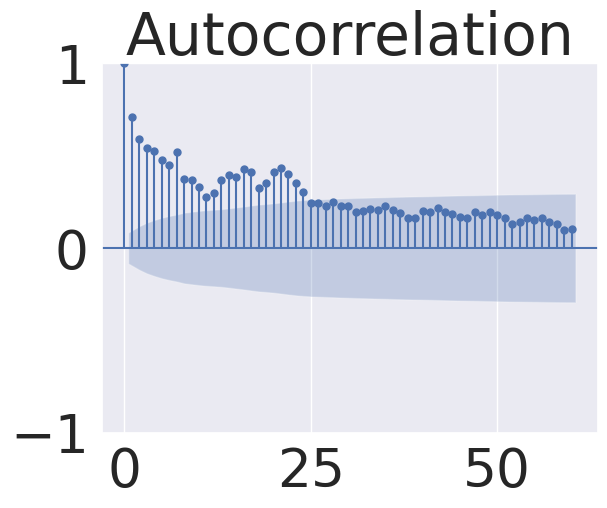

In [46]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

## Augmented Dicky Fuller Test
First element of output is the test statistic. Test statistic shows how likely the data is stationary
Second element indicates the p-value. If p-value is >0.05, reject null hypothesis or else not, The null hypothesis is that data is not stationary.

In [47]:
test = adfuller(top_page_df['Views'])
print(test)

(-2.207607515248962, 0.20349596325525338, 14, 535, {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}, 2833.3812256580777)


The data is not stationary as per the values.



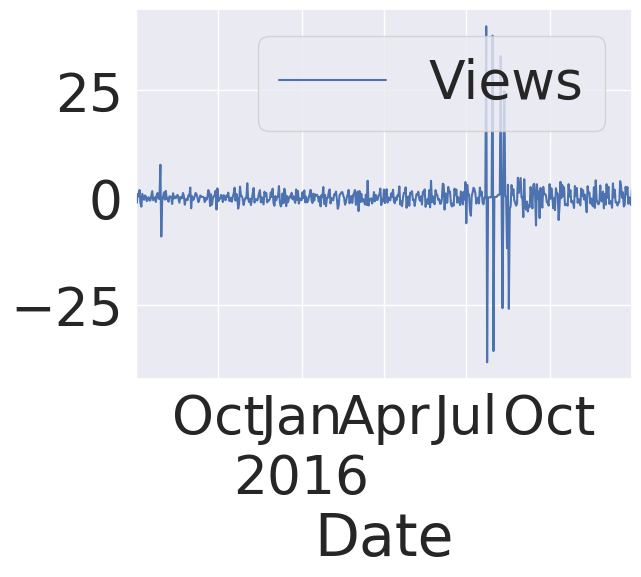

In [48]:
# Differencing the data to make it stationary
top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

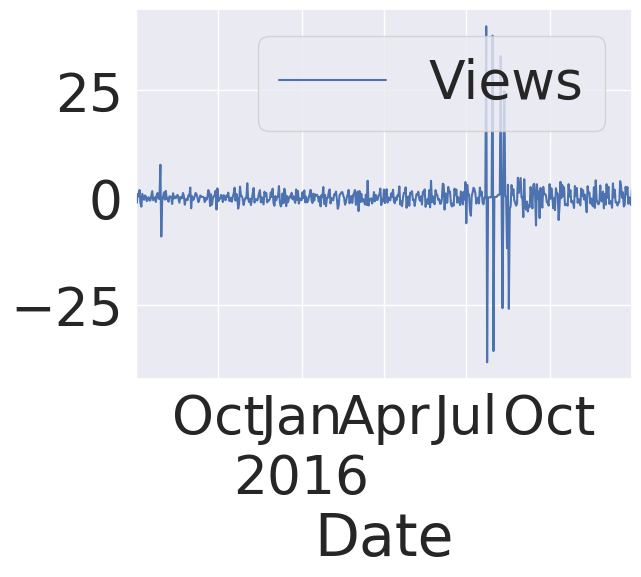

In [49]:
# Differencing the data to make it stationary
top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

In [50]:
# Augmented dicky-fuller test on stationary data
test2 = adfuller(top_page_stationary_df['Views'])
print(test2)

(-8.584491969541022, 7.571666589560141e-14, 19, 529, {'1%': -3.442772146350605, '5%': -2.8670191055991836, '10%': -2.5696881663873414}, 2829.1724250611987)


Data is stationary



In [51]:
top_page_df


,Views
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77
...,...
2016-12-27,26.92
2016-12-28,27.03
2016-12-29,26.07


In [52]:
# preparing data for modelling
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

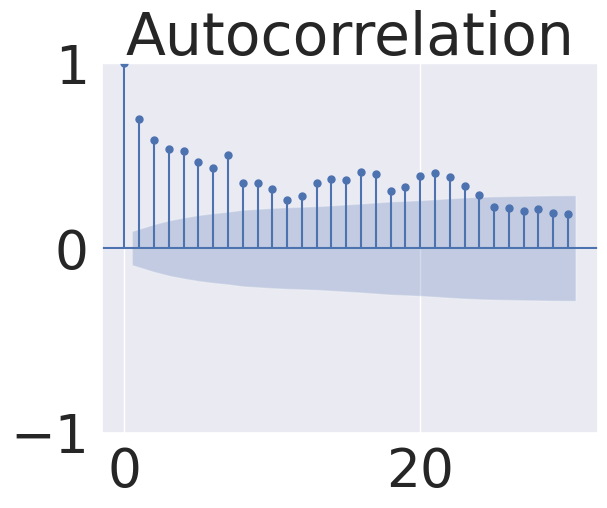

In [53]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


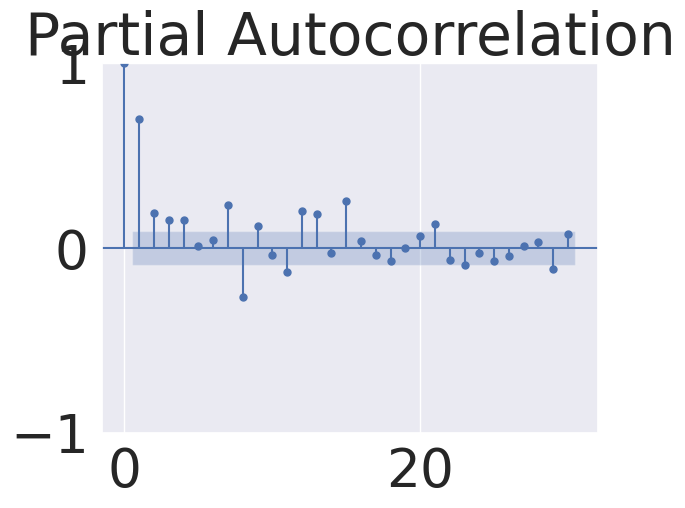

In [54]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

## 4. ARMA Model


In [55]:
aic_bic_values = []
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(train, order=(p,0,q))
            result = model.fit()
            aic_bic_values.append((p,q,result.aic,result.bic))
        except:
            continue

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, s

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.46742D+00    |proj g|=  2.24709D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.247D-08   4.467D+00
  F =   4.4674165638756724     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.1

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.49684D+00    |proj g|=  1.80080D-01

At iterate   15    f=  3.48320D+00    |proj g|=  6.88229D-03

At iterate   20    f=  3.48291D+00    |proj g|=  5.56968D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     27      1     0     0   1.381D-05   3.483D+00
  F =   3.4829071753814813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03671D+00    |proj g|=  1.10587D-01

At iterate    5    f=  3.83472D+00    |proj g|=  3.26378D-01

At iterate   10    f=  3.63290D+00    |proj g|=  5.69433D-02

At iterate   15    f=  3.50909D+00    |proj g|=  3.32846D-01

At iterate   20    f=  3.33337D+00    |proj g|=  4.24141D-02

At iterate   25    f=  3.32930D+00    |proj g|=  3.12836D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     40      1     0     0   

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01975D+00    |proj g|=  9.54840D-02

At iterate    5    f=  3.88070D+00    |proj g|=  1.27090D-01

At iterate   10    f=  3.32989D+00    |proj g|=  8.98406D-01

At iterate   15    f=  3.23106D+00    |proj g|=  1.21478D-01

At iterate   20    f=  3.20772D+00    |proj g|=  4.38603D-02

At iterate   25    f=  3.18486D+00    |proj g|=  2.08816D-01

At iterate   30    f=  3.17196D+00    |proj g|=  8.28306D-02

At iterate   35    f=  3.17154D+00    |proj g|=  1.48850D-03

At iterate   40    f=  3.17151D+00    |proj g|=  6.66099D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01584D+00    |proj g|=  7.34620D-02

At iterate    5    f=  3.79641D+00    |proj g|=  1.29545D-01

At iterate   10    f=  3.35215D+00    |proj g|=  1.38175D-01

At iterate   15    f=  3.17683D+00    |proj g|=  1.76407D-01

At iterate   20    f=  3.16540D+00    |proj g|=  2.27173D-02

At iterate   25    f=  3.16336D+00    |proj g|=  1.44473D-02

At iterate   30    f=  3.16210D+00    |proj g|=  5.65137D-03

At iterate   35    f=  3.16208D+00    |proj g|=  1.42417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, s

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96078D+00    |proj g|=  3.23314D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   5.986D-06   2.961D+00
  F =   2.9607779999142902     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.8

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85368D+00    |proj g|=  2.92132D-02

At iterate    5    f=  2.85190D+00    |proj g|=  5.28028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   4.537D-06   2.852D+00
  F =   2.8519007180885554     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  2.85763D+00    |proj g|=  1.01368D-02

At iterate   10    f=  2.85722D+00    |proj g|=  5.25095D-03

At iterate   15    f=  2.85268D+00    |proj g|=  4.77532D-03

At iterate   20    f=  2.85190D+00    |proj g|=  5.43582D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   3.093D-06   2.852D+00
  F =   2.8518971209261399     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85844D+00    |proj g|=  6.97612D-02

At iterate    5    f=  2.83666D+00    |proj g|=  4.16443D-02

At iterate   10    f=  2.83295D+00    |proj g|=  2.78544D-03

At iterate   15    f=  2.83221D+00    |proj g|=  1.13922D-02

At iterate   20    f=  2.82717D+00    |proj g|=  3.49830D-02

At iterate   25    f=  2.82351D+00    |proj g|=  3.56493D-03

At iterate   30    f=  2.82333D+00    |proj g|=  3.01594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.82819D+00    |proj g|=  3.21530D-02

At iterate   10    f=  2.82645D+00    |proj g|=  4.23076D-03

At iterate   15    f=  2.82638D+00    |proj g|=  3.11691D-03

At iterate   20    f=  2.82547D+00    |proj g|=  1.04673D-02

At iterate   25    f=  2.82255D+00    |proj g|=  7.90540D-03

At iterate   30    f=  2.82193D+00    |proj g|=  1.74441D-03

At iterate   35    f=  2.82192D+00    |proj g|=  1.38306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     40      1     0     0   8.199D-06   2.822D+00
  F =   2.8219174009667189     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, s

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86359D+00    |proj g|=  7.74275D-02

At iterate    5    f=  2.85146D+00    |proj g|=  6.88333D-03

At iterate   10    f=  2.85083D+00    |proj g|=  2.09556D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   2.096D-05   2.851D+00
  F =   2.8508319507697841     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  3.00497D+01    |proj g|=  4.93979D+01

At iterate   10    f=  5.56403D+00    |proj g|=  1.61713D+00

At iterate   15    f=  2.98061D+00    |proj g|=  7.32656D-02

At iterate   20    f=  2.85218D+00    |proj g|=  9.00061D-03

At iterate   25    f=  2.85156D+00    |proj g|=  2.21143D-03

At iterate   30    f=  2.85072D+00    |proj g|=  6.01503D-03

At iterate   35    f=  2.85052D+00    |proj g|=  1.55194D-03

At iterate   40    f=  2.85036D+00    |proj g|=  6.68317D-03

At iterate   45    f=  2.85032D+00    |proj g|=  3.79457D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     52   

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.84716D+00    |proj g|=  9.64221D-03

At iterate   10    f=  2.84329D+00    |proj g|=  9.09354D-04

At iterate   15    f=  2.84323D+00    |proj g|=  6.55491D-03

At iterate   20    f=  2.84284D+00    |proj g|=  1.08740D-03

At iterate   25    f=  2.84282D+00    |proj g|=  1.28470D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     28      1     0     0   7.442D-06   2.843D+00
  F =   2.8428207369563090     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.84861D+00    |proj g|=  1.77156D-02

At iterate   10    f=  2.84180D+00    |proj g|=  9.33551D-03

At iterate   15    f=  2.84141D+00    |proj g|=  8.06414D-04

At iterate   20    f=  2.84141D+00    |proj g|=  2.00188D-04

At iterate   25    f=  2.84139D+00    |proj g|=  2.35116D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     31      1     0     0   3.376D-05   2.841D+00
  F =   2.8413874139882975     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80048D+00    |proj g|=  8.97045D-02

At iterate    5    f=  2.78413D+00    |proj g|=  1.13055D-02

At iterate   10    f=  2.78254D+00    |proj g|=  3.00397D-03

At iterate   15    f=  2.78243D+00    |proj g|=  1.87891D-04

At iterate   20    f=  2.78243D+00    |proj g|=  6.27330D-04

At iterate   25    f=  2.78236D+00    |proj g|=  5.85960D-03

At iterate   30    f=  2.78215D+00    |proj g|=  7.86925D-04

At iterate   35    f=  2.78215D+00    |proj g|=  2.09661D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88751D+00    |proj g|=  1.02138D-03

At iterate    5    f=  2.88750D+00    |proj g|=  3.67252D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   3.350D-05   2.888D+00
  F =   2.8875030321480497     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85702D+00    |proj g|=  2.82656D-02

At iterate    5    f=  2.85191D+00    |proj g|=  7.01515D-03

At iterate   10    f=  2.84574D+00    |proj g|=  7.78729D-03

At iterate   15    f=  2.84444D+00    |proj g|=  2.40793D-04

At iterate   20    f=  2.84444D+00    |proj g|=  4.28971D-04

At iterate   25    f=  2.84439D+00    |proj g|=  1.04984D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     36      1     0     0   

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91364D+00    |proj g|=  2.47032D-01

At iterate    5    f=  2.90277D+00    |proj g|=  2.39053D-01

At iterate   10    f=  2.88797D+00    |proj g|=  1.03480D-01

At iterate   15    f=  2.87370D+00    |proj g|=  1.99239D-02

At iterate   20    f=  2.87102D+00    |proj g|=  2.43251D-02

At iterate   25    f=  2.87092D+00    |proj g|=  1.43862D-02

At iterate   30    f=  2.87042D+00    |proj g|=  9.92383D-03

At iterate   35    f=  2.87037D+00    |proj g|=  1.40133D-03

At iterate   40    f=  2.87033D+00    |proj g|=  1.34213D-02

At iterate   45    f=  2.87009D+00    |proj g|=  1.48142D-02

At iterate   50    f=  2.87003D+00    |proj g|=  4.64791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86132D+00    |proj g|=  2.87118D-01

At iterate    5    f=  2.81195D+00    |proj g|=  3.57124D-02

At iterate   10    f=  2.79236D+00    |proj g|=  9.63766D-02

At iterate   15    f=  2.78813D+00    |proj g|=  3.78243D-02

At iterate   20    f=  2.78702D+00    |proj g|=  4.24981D-03

At iterate   25    f=  2.78687D+00    |proj g|=  1.77375D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     34      1     0     0   

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86230D+00    |proj g|=  2.09568D+00

At iterate    5    f=  2.83575D+00    |proj g|=  3.40561D-02

At iterate   10    f=  2.82843D+00    |proj g|=  1.27640D-02

At iterate   15    f=  2.82817D+00    |proj g|=  3.23166D-03

At iterate   20    f=  2.82814D+00    |proj g|=  4.05946D-04

At iterate   25    f=  2.82814D+00    |proj g|=  1.25950D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     26     32      1     0     0   

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79130D+00    |proj g|=  8.21237D-01

At iterate    5    f=  2.77764D+00    |proj g|=  1.65799D-01

At iterate   10    f=  2.77329D+00    |proj g|=  1.14086D-01

At iterate   15    f=  2.77107D+00    |proj g|=  8.98312D-02

At iterate   20    f=  2.77097D+00    |proj g|=  4.53522D-03

At iterate   25    f=  2.77093D+00    |proj g|=  6.04205D-03

At iterate   30    f=  2.77087D+00    |proj g|=  2.57450D-03

At iterate   35    f=  2.77074D+00    |proj g|=  1.85170D-02

At iterate   40    f=  2.77037D+00    |proj g|=  4.37934D-02

At iterate   45    f=  2.77023D+00    |proj g|=  2.22690D-03


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.77021D+00    |proj g|=  7.63487D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   7.635D-04   2.770D+00
  F =   2.7702124522023466     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86750D+00    |proj g|=  1.54566D-03

At iterate    5    f=  2.86749D+00    |proj g|=  3.12805D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.86797D+00    |proj g|=  8.16152D-03

At iterate   15    f=  2.86515D+00    |proj g|=  4.65941D-02

At iterate   20    f=  2.85506D+00    |proj g|=  4.52949D-02

At iterate   25    f=  2.84814D+00    |proj g|=  2.39516D-03

At iterate   30    f=  2.84755D+00    |proj g|=  2.46631D-03

At iterate   35    f=  2.84745D+00    |proj g|=  1.66952D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     43      1     0     0   7.691D-06   2.847D+00
  F =   2.8474508159810239     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.85371D+00    |proj g|=  3.53667D-02

At iterate   10    f=  2.84658D+00    |proj g|=  5.76698D-03

At iterate   15    f=  2.84581D+00    |proj g|=  1.11370D-03

At iterate   20    f=  2.84529D+00    |proj g|=  3.01887D-03

At iterate   25    f=  2.84342D+00    |proj g|=  1.85827D-02

At iterate   30    f=  2.84065D+00    |proj g|=  2.07998D-03

At iterate   35    f=  2.84009D+00    |proj g|=  3.32208D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     47      1     0     0   5.913D-06   2.840D+00
  F =   2.8400870963656786     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.89385D+00    |proj g|=  7.08333D-02

At iterate   10    f=  2.81543D+00    |proj g|=  6.34403D-02

At iterate   15    f=  2.79245D+00    |proj g|=  8.79494D-02

At iterate   20    f=  2.78987D+00    |proj g|=  1.84392D-02

At iterate   25    f=  2.78814D+00    |proj g|=  4.40467D-03

At iterate   30    f=  2.78792D+00    |proj g|=  8.93338D-02

At iterate   35    f=  2.78721D+00    |proj g|=  5.16651D-02

At iterate   40    f=  2.78705D+00    |proj g|=  9.70238D-03

At iterate   45    f=  2.78703D+00    |proj g|=  1.26935D-02


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.78703D+00    |proj g|=  9.24670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   9.247D-04   2.787D+00
  F =   2.7870295159035874     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85142D+00    |proj g|=  4.56791D-01

At iterate    5    f=  2.81367D+00    |proj g|=  6.11452D-02

At iterate   10    f=  2.79711D+00    |proj g|=  1.10256D-01

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.78073D+00    |proj g|=  5.74170D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59      1     0     0   5.742D-02   2.781D+00
  F =   2.7807256486765715     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39363D+00    |proj g|=  8.89210D-01

At iterate    5    f=  2.84499D+00    |proj g|=  7.01661D-02

At iterate   10    f=  2.80127D+00    |proj g|=  6.62054D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.77306D+00    |proj g|=  1.37120D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   1.371D-02   2.773D+00
  F =   2.7730567045979475     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09580D+00    |proj g|=  5.12610D-01

At iterate    5    f=  2.78953D+00    |proj g|=  4.97755D-02

At iterate   10    f=  2.77220D+00    |proj g|=  4.64254D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.75355D+00    |proj g|=  2.67716D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56      1     0     0   2.677D-03   2.754D+00
  F =   2.7535549557364640     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86605D+00    |proj g|=  2.05026D-03

At iterate    5    f=  2.86603D+00    |proj g|=  2.55092D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.86630D+00    |proj g|=  2.14059D-03

At iterate   10    f=  2.86527D+00    |proj g|=  6.51295D-02

At iterate   15    f=  2.85612D+00    |proj g|=  5.53878D-02

At iterate   20    f=  2.84969D+00    |proj g|=  2.81784D-03

At iterate   25    f=  2.84963D+00    |proj g|=  1.98343D-03

At iterate   30    f=  2.84806D+00    |proj g|=  2.45219D-02

At iterate   35    f=  2.84727D+00    |proj g|=  1.14965D-03

At iterate   40    f=  2.84727D+00    |proj g|=  2.41469D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     53      1     0     0   2.415D-06   2.847D+00
  F =   2.84727056362

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86539D+00    |proj g|=  1.06654D-01

At iterate    5    f=  2.84955D+00    |proj g|=  3.43070D-02

At iterate   10    f=  2.84508D+00    |proj g|=  3.29077D-03

At iterate   15    f=  2.84489D+00    |proj g|=  1.24748D-03

At iterate   20    f=  2.84346D+00    |proj g|=  1.99685D-02

At iterate   25    f=  2.84174D+00    |proj g|=  8.47564D-03

At iterate   30    f=  2.84016D+00    |proj g|=  1.81086D-03

At iterate   35    f=  2.84008D+00    |proj g|=  1.66160D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.88467D+00    |proj g|=  3.73151D-02

At iterate   10    f=  2.83910D+00    |proj g|=  7.88729D-02

At iterate   15    f=  2.81562D+00    |proj g|=  1.12639D-02

At iterate   20    f=  2.81311D+00    |proj g|=  2.60925D-02

At iterate   25    f=  2.79526D+00    |proj g|=  6.59474D-02

At iterate   30    f=  2.78981D+00    |proj g|=  9.18421D-03

At iterate   35    f=  2.78714D+00    |proj g|=  5.10795D-02

At iterate   40    f=  2.78561D+00    |proj g|=  1.82334D-02

At iterate   45    f=  2.78526D+00    |proj g|=  3.83431D-03


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.78376D+00    |proj g|=  1.47556D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63      1     0     0   1.476D-02   2.784D+00
  F =   2.7837644296439614     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84260D+00    |proj g|=  4.32484D-01

At iterate    5    f=  2.82146D+00    |proj g|=  2.73550D-02

At iterate   10    f=  2.81206D+00    |proj g|=  1.30434D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.77910D+00    |proj g|=  5.50634D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   5.506D-02   2.779D+00
  F =   2.7790990846295154     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44943D+00    |proj g|=  9.36984D-01

At iterate    5    f=  2.81178D+00    |proj g|=  6.43090D-02

At iterate   10    f=  2.77952D+00    |proj g|=  9.23197D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.77384D+00    |proj g|=  1.45797D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     57      1     0     0   1.458D-02   2.774D+00
  F =   2.7738365019824771     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27193D+00    |proj g|=  8.48286D-01

At iterate    5    f=  2.78868D+00    |proj g|=  4.57495D-02

At iterate   10    f=  2.77090D+00    |proj g|=  4.80817D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.75536D+00    |proj g|=  6.79119D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   6.791D-03   2.755D+00
  F =   2.7553614252837293     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86286D+00    |proj g|=  2.43263D-03

At iterate    5    f=  2.86283D+00    |proj g|=  1.12582D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.86518D+00    |proj g|=  1.94699D-02

At iterate   10    f=  2.86241D+00    |proj g|=  4.18402D-03

At iterate   15    f=  2.86153D+00    |proj g|=  8.69356D-03

At iterate   20    f=  2.85556D+00    |proj g|=  4.93132D-03

At iterate   25    f=  2.85154D+00    |proj g|=  3.25274D-02

At iterate   30    f=  2.84403D+00    |proj g|=  4.43068D-03

At iterate   35    f=  2.84363D+00    |proj g|=  6.40173D-03

At iterate   40    f=  2.84269D+00    |proj g|=  8.46908D-04

At iterate   45    f=  2.84266D+00    |proj g|=  8.30885D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     57   

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.86495D+00    |proj g|=  2.95575D-02

At iterate   10    f=  2.86218D+00    |proj g|=  4.88013D-02

At iterate   15    f=  2.85361D+00    |proj g|=  2.74988D-02

At iterate   20    f=  2.84764D+00    |proj g|=  3.16431D-02

At iterate   25    f=  2.84245D+00    |proj g|=  4.17918D-02

At iterate   30    f=  2.83863D+00    |proj g|=  2.49457D-02

At iterate   35    f=  2.83754D+00    |proj g|=  1.63050D-02

At iterate   40    f=  2.83722D+00    |proj g|=  3.82049D-03

At iterate   45    f=  2.83700D+00    |proj g|=  1.19078D-02

At iterate   50    f=  2.83698D+00    |proj g|=  1.48933D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64184D+01    |proj g|=  2.74872D+01

At iterate    5    f=  2.89771D+00    |proj g|=  5.52163D-02

At iterate   10    f=  2.86535D+00    |proj g|=  1.16754D-01

At iterate   15    f=  2.81620D+00    |proj g|=  4.99768D-02

At iterate   20    f=  2.80775D+00    |proj g|=  1.20147D-02

At iterate   25    f=  2.80551D+00    |proj g|=  1.43542D-02

At iterate   30    f=  2.80342D+00    |proj g|=  1.50605D-02

At iterate   35    f=  2.79915D+00    |proj g|=  4.43805D-02

At iterate   40    f=  2.79351D+00    |proj g|=  9.69945D-03

At iterate   45    f=  2.79188D+00    |proj g|=  1.19687D-02

At iterate   50    f=  2.78893D+00    |proj g|=  6.91652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84469D+00    |proj g|=  4.45723D-01

At iterate    5    f=  2.81671D+00    |proj g|=  4.69830D-02

At iterate   10    f=  2.76954D+00    |proj g|=  4.74491D-02

At iterate   15    f=  2.75074D+00    |proj g|=  3.49499D-02

At iterate   20    f=  2.74819D+00    |proj g|=  1.28491D-02

At iterate   25    f=  2.74714D+00    |proj g|=  3.85466D-03

At iterate   30    f=  2.74705D+00    |proj g|=  2.62738D-03

At iterate   35    f=  2.74651D+00    |proj g|=  4.06784D-02

At iterate   40    f=  2.74549D+00    |proj g|=  8.66878D-03

At iterate   45    f=  2.74537D+00    |proj g|=  3.12160D-03


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.74532D+00    |proj g|=  1.05953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     53      1     0     0   1.060D-03   2.745D+00
  F =   2.7453180876616772     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45312D+00    |proj g|=  9.47095D-01

At iterate    5    f=  2.90767D+00    |proj g|=  1.71103D-01

At iterate   10    f=  2.80077D+00    |proj g|=  4.42867D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.74278D+00    |proj g|=  5.41410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     55      1     0     0   5.414D-04   2.743D+00
  F =   2.7427816510818572     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18366D+00    |proj g|=  6.93117D-01

At iterate    5    f=  2.79981D+00    |proj g|=  7.58682D-02

At iterate   10    f=  2.77110D+00    |proj g|=  1.98864D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [56]:
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
aic_bic_df = aic_bic_df.sort_values(by=['aic','bic'])

In [57]:
# prediction using ARMA model
model = SARIMAX(train,order=(int(aic_bic_df.iloc[0]['p']),0,int(aic_bic_df.iloc[0]['q'])))
result = model.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45312D+00    |proj g|=  9.47095D-01

At iterate    5    f=  2.90767D+00    |proj g|=  1.71103D-01

At iterate   10    f=  2.80077D+00    |proj g|=  4.42867D-02

At iterate   15    f=  2.77255D+00    |proj g|=  1.89120D-02

At iterate   20    f=  2.75376D+00    |proj g|=  3.17804D-02

At iterate   25    f=  2.74604D+00    |proj g|=  5.52503D-02

At iterate   30    f=  2.74369D+00    |proj g|=  8.87063D-03

At iterate   35    f=  2.74311D+00    |proj g|=  4.10676D-03

At iterate   40    f=  2.74285D+00    |proj g|=  5.64282D-03

At iterate   45    f=  2.74278D+00    |proj g|=  3.34995D-04

At iterate   50    f=  2.74278D+00    |proj g|=  5.41410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [58]:
import pickle
with open('arma_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [59]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()

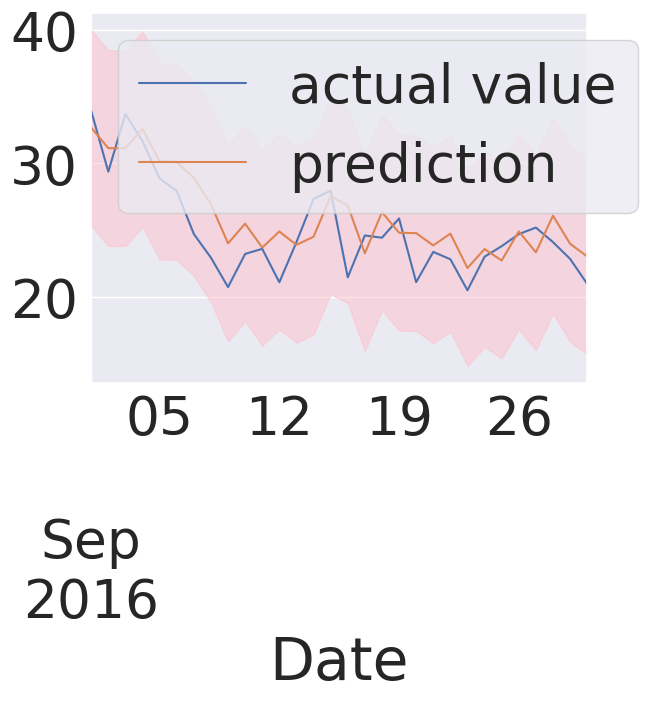

In [60]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax,label='prediction')
plt.fill_between(confidence_interval.index, \
                confidence_interval['lower Views'], \
                confidence_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.legend()
plt.show()

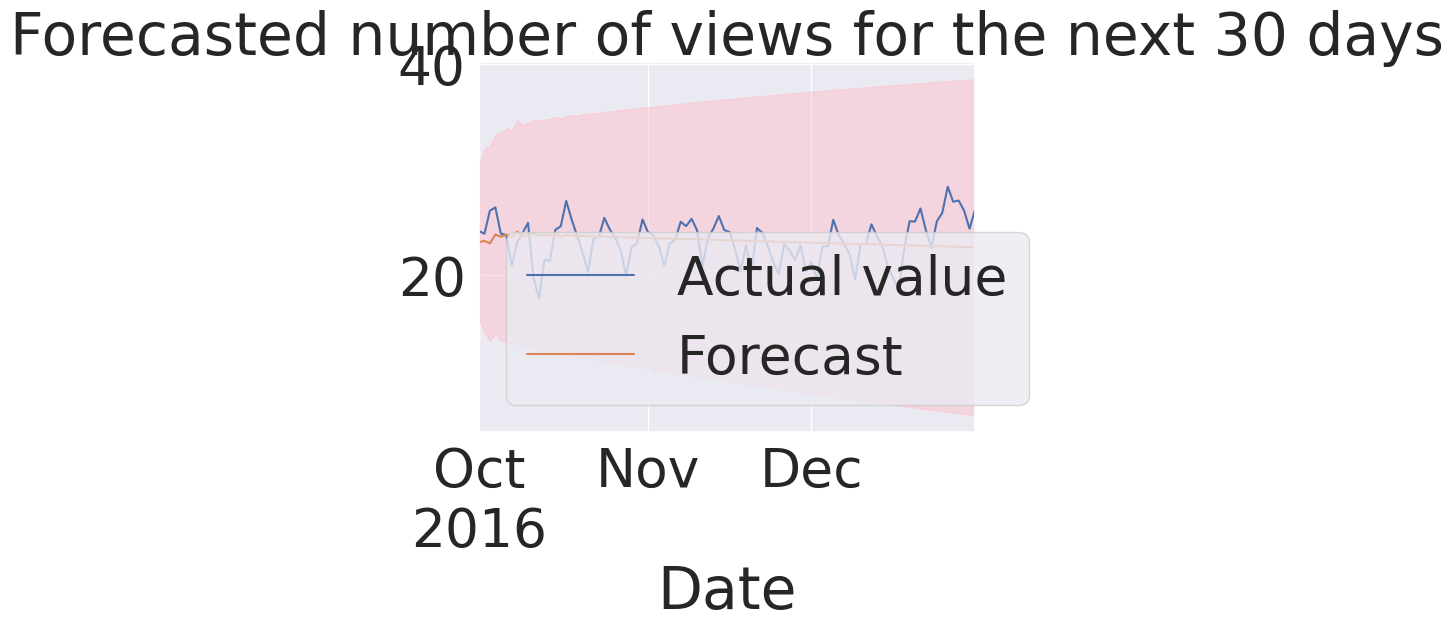

In [61]:
# forecasting using ARMA model
forecast_values = result.get_forecast(steps=test.shape[0])
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

arma_forecast_df = pd.DataFrame({'Date':test.index,'Views':forecast_values.predicted_mean,'lower_views':conf_interval['lower Views'].values,'upper_views':conf_interval['upper Views'].values})
arma_forecast_df = arma_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arma_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax,label='Forecast')
plt.fill_between(arma_forecast_df.index, \
                arma_forecast_df.lower_views, \
                arma_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [62]:
rmse_values = []
rmse_values.append(('ARMA',np.sqrt(np.mean(np.square(forecast_values_mean.values - test.Views.values)))))

In [63]:
print(rmse_values)

[('ARMA', 2.15276517998977)]


## 5. ARIMA Model


In [64]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(train, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
arima_aic_bic_df = arima_aic_bic_df.sort_values(by=['aic','bic'])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95727D+00    |proj g|=  4.65893D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   8.500D-08   2.957D+00
  F =   2.9572666591973857     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.8

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, s

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84961D+00    |proj g|=  4.43081D-02

At iterate    5    f=  2.84237D+00    |proj g|=  2.05858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   6.750D-06   2.842D+00
  F =   2.8423482052495865     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85116D+00    |proj g|=  4.57523D-02

At iterate    5    f=  2.84309D+00    |proj g|=  2.78193D-02

At iterate   10    f=  2.84235D+00    |proj g|=  7.34092D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   7.298D-06   2.842D+00
  F =   2.8423478766003800     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85034D+00    |proj g|=  7.49635D-02


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.81712D+00    |proj g|=  3.21476D-02

At iterate   10    f=  2.81363D+00    |proj g|=  9.64374D-04

At iterate   15    f=  2.81362D+00    |proj g|=  2.30961D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     17      1     0     0   2.310D-05   2.814D+00
  F =   2.8136239403636236     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83143D+00    |proj g|=  8.53291D-02


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.81529D+00    |proj g|=  2.42887D-02

At iterate   10    f=  2.81232D+00    |proj g|=  7.56232D-03

At iterate   15    f=  2.81218D+00    |proj g|=  4.13923D-04

At iterate   20    f=  2.81218D+00    |proj g|=  1.56370D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     25      1     0     0   1.144D-05   2.812D+00
  F =   2.8121775005212259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, s

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85285D+00    |proj g|=  3.36918D-02

At iterate    5    f=  2.84985D+00    |proj g|=  3.05122D-02

At iterate   10    f=  2.83998D+00    |proj g|=  1.44319D-02

At iterate   15    f=  2.83880D+00    |proj g|=  7.35947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     19      1     0     0   7.212D-06   2.839D+00
  F =   2.8387979504567853     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  2.84143D+00    |proj g|=  8.81907D-04

At iterate   15    f=  2.84140D+00    |proj g|=  2.50480D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     16      1     0     0   2.505D-06   2.841D+00
  F =   2.8414007905729513     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87861D+00    |proj g|=  2.09073D-01


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.83864D+00    |proj g|=  2.67115D-02

At iterate   10    f=  2.83427D+00    |proj g|=  1.63102D-02

At iterate   15    f=  2.83326D+00    |proj g|=  2.65750D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   1.209D-05   2.833D+00
  F =   2.8332520065892162     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87832D+00    |proj g|=  2.06027D-01


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.83858D+00    |proj g|=  1.42794D-02

At iterate   10    f=  2.83210D+00    |proj g|=  4.78683D-03

At iterate   15    f=  2.83194D+00    |proj g|=  4.05147D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   1.471D-05   2.832D+00
  F =   2.8319369417533675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79173D+00    |proj g|=  1.05809D-01

At iterate    5    f=  2.77381D+00    |proj g|=  1.39235D-02

At iterate   10    f=  2.77241D+00    |proj g|=  1.46753D-03

At iterate   15    f=  2.77240D+00    |proj g|=  1.13412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     17     20      1     0     0   5.291D-06   2.772D+00
  F =   2.7724006855657661     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   9.065D-06   2.880D+00
  F =   2.8798150481117881     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84223D+00    |proj g|=  4.07114D-02

At iterate    5    f=  2.83987D+00    |proj g|=  3.21340D-03

At iterate   10    f=  2.83950D+00    |proj g|=  7.84524D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.84145D+00    |proj g|=  1.98583D-02

At iterate   10    f=  2.84041D+00    |proj g|=  9.83538D-04

At iterate   15    f=  2.84022D+00    |proj g|=  8.01272D-03

At iterate   20    f=  2.83961D+00    |proj g|=  1.64516D-02

At iterate   25    f=  2.83719D+00    |proj g|=  1.53987D-02

At iterate   30    f=  2.83591D+00    |proj g|=  9.96955D-04

At iterate   35    f=  2.83590D+00    |proj g|=  5.06923D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     43      1     0     0   5.069D-06   2.836D+00
  F =   2.8358997823471261     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.84133D+00    |proj g|=  1.96599D-02

At iterate   15    f=  2.83677D+00    |proj g|=  1.63238D-03

At iterate   20    f=  2.83672D+00    |proj g|=  7.86435D-05

At iterate   25    f=  2.83672D+00    |proj g|=  1.05095D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     29      1     0     0   1.317D-05   2.837D+00
  F =   2.8367237617609100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.82694D+00    |proj g|=  1.31342D-01

At iterate   10    f=  2.81865D+00    |proj g|=  6.42215D-03

At iterate   15    f=  2.81831D+00    |proj g|=  9.91602D-03

At iterate   20    f=  2.81819D+00    |proj g|=  1.70709D-03

At iterate   25    f=  2.81812D+00    |proj g|=  2.84035D-03

At iterate   30    f=  2.81360D+00    |proj g|=  1.65810D-01

At iterate   35    f=  2.79774D+00    |proj g|=  2.19703D-02

At iterate   40    f=  2.79179D+00    |proj g|=  5.35924D-02

At iterate   45    f=  2.78885D+00    |proj g|=  5.99138D-03

At iterate   50    f=  2.78876D+00    |proj g|=  2.29109D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43909D+00    |proj g|=  9.86136D-01

At iterate    5    f=  2.79237D+00    |proj g|=  8.02648D-02

At iterate   10    f=  2.77169D+00    |proj g|=  5.99053D-02

At iterate   15    f=  2.76493D+00    |proj g|=  1.38844D-02

At iterate   20    f=  2.76417D+00    |proj g|=  6.53618D-03

At iterate   25    f=  2.76411D+00    |proj g|=  6.05657D-04

At iterate   30    f=  2.76411D+00    |proj g|=  2.61213D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.76392D+00    |proj g|=  3.51611D-02

At iterate   10    f=  2.76145D+00    |proj g|=  1.63620D-02

At iterate   15    f=  2.76071D+00    |proj g|=  3.98424D-03

At iterate   20    f=  2.76002D+00    |proj g|=  2.23640D-02

At iterate   25    f=  2.75970D+00    |proj g|=  5.38226D-03

At iterate   30    f=  2.75969D+00    |proj g|=  3.92225D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     40      1     0     0   1.019D-04   2.760D+00
  F =   2.7596874592953564     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85910D+00    |proj g|=  1.49897D-03

At iterate    5    f=  2.85909D+00    |proj g|=  4.09939D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   4.099D-06   2.859D+00
  F =   2.8590861803238656     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.83861D+00    |proj g|=  3.58376D-03

At iterate   15    f=  2.83715D+00    |proj g|=  7.90425D-03

At iterate   20    f=  2.83192D+00    |proj g|=  1.23618D-02

At iterate   25    f=  2.83038D+00    |proj g|=  2.97687D-03

At iterate   30    f=  2.83037D+00    |proj g|=  2.88871D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     34      1     0     0   2.889D-06   2.830D+00
  F =   2.8303692676943886     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90629D+00    |proj g|=  3.05018D-01

At iterate    5    f=  2.83007D+00    |proj g|=  3.12682D-02

At iterate   10    f=  2.82289D+00    |proj g|=  1.40412D-02

At iterate   15    f=  2.82111D+00    |proj g|=  1.36325D-03

At iterate   20    f=  2.82023D+00    |proj g|=  3.42147D-03

At iterate   25    f=  2.81861D+00    |proj g|=  1.85702D-02

At iterate   30    f=  2.81231D+00    |proj g|=  8.82328D-03

At iterate   35    f=  2.81002D+00    |proj g|=  7.63269D-03

At iterate   40    f=  2.80903D+00    |proj g|=  1.89019D-03

At iterate   45    f=  2.80894D+00    |proj g|=  8.41134D-04


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.80893D+00    |proj g|=  1.75599D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.756D-04   2.809D+00
  F =   2.8089251077209410     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38820D+00    |proj g|=  9.02383D-01

At iterate    5    f=  2.81182D+00    |proj g|=  5.76187D-02

At iterate   10    f=  2.78387D+00    |proj g|=  3.92111D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.76625D+00    |proj g|=  4.62615D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   4.626D-04   2.766D+00
  F =   2.7662522226726325     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85355D+00    |proj g|=  8.54056D-01

At iterate    5    f=  2.82628D+00    |proj g|=  4.34885D-02

At iterate   10    f=  2.81788D+00    |proj g|=  1.99809D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.77795D+00    |proj g|=  7.30137D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     68      1     0     0   7.301D-03   2.778D+00
  F =   2.7779535585736470     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77890D+00    |proj g|=  6.53190D-02

At iterate    5    f=  2.77054D+00    |proj g|=  2.21703D-02

At iterate   10    f=  2.76658D+00    |proj g|=  2.00692D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85749D+00    |proj g|=  2.00789D-03

At iterate    5    f=  2.85747D+00    |proj g|=  1.36974D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   1.045D-06   2.857D+00
  F =   2.8574723408831089     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.85018D+00    |proj g|=  1.32124D-02

At iterate   10    f=  2.84004D+00    |proj g|=  2.77877D-02

At iterate   15    f=  2.83651D+00    |proj g|=  6.40061D-03

At iterate   20    f=  2.83152D+00    |proj g|=  9.78357D-03

At iterate   25    f=  2.83036D+00    |proj g|=  1.43511D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     35      1     0     0   7.648D-06   2.830D+00
  F =   2.8303582675738848     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.82589D+00    |proj g|=  5.55726D-03

At iterate   10    f=  2.82192D+00    |proj g|=  1.33934D-02

At iterate   15    f=  2.82065D+00    |proj g|=  3.39437D-03

At iterate   20    f=  2.82053D+00    |proj g|=  1.27166D-03

At iterate   25    f=  2.82017D+00    |proj g|=  4.42247D-03

At iterate   30    f=  2.81568D+00    |proj g|=  5.68478D-02

At iterate   35    f=  2.80868D+00    |proj g|=  1.15973D-02

At iterate   40    f=  2.80640D+00    |proj g|=  2.61178D-03

At iterate   45    f=  2.80626D+00    |proj g|=  1.34415D-03


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.80607D+00    |proj g|=  4.23634D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   4.236D-03   2.806D+00
  F =   2.8060730654095583     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83422D+00    |proj g|=  3.96470D-01

At iterate    5    f=  2.82335D+00    |proj g|=  3.85411D-02

At iterate   10    f=  2.81868D+00    |proj g|=  4.01934D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.77170D+00    |proj g|=  1.83015D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65      1     0     0   1.830D-02   2.772D+00
  F =   2.7717011831776017     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84225D+00    |proj g|=  3.41463D-01

At iterate    5    f=  2.82525D+00    |proj g|=  4.38426D-02

At iterate   10    f=  2.81772D+00    |proj g|=  8.59490D-03

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.79886D+00    |proj g|=  2.62900D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60      1     0     0   2.629D-02   2.799D+00
  F =   2.7988606934810054     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77503D+00    |proj g|=  3.72478D-02

At iterate    5    f=  2.76329D+00    |proj g|=  2.98824D-02

At iterate   10    f=  2.75108D+00    |proj g|=  3.14398D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.74819D+00    |proj g|=  1.21217D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     61      1     0     0   1.212D-02   2.748D+00
  F =   2.7481948324337915     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85411D+00    |proj g|=  2.41928D-03

At iterate    5    f=  2.85408D+00    |proj g|=  1.18289D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.84660D+00    |proj g|=  1.22029D-02

At iterate   10    f=  2.84049D+00    |proj g|=  4.03817D-02

At iterate   15    f=  2.83355D+00    |proj g|=  1.06159D-02

At iterate   20    f=  2.83284D+00    |proj g|=  1.24234D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     28      1     0     0   9.640D-06   2.833D+00
  F =   2.8328345776487018     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.84989D+00    |proj g|=  9.85033D-03

At iterate   10    f=  2.84133D+00    |proj g|=  3.11657D-02

At iterate   15    f=  2.83371D+00    |proj g|=  5.90479D-03

At iterate   20    f=  2.83309D+00    |proj g|=  1.45563D-03

At iterate   25    f=  2.83285D+00    |proj g|=  3.64310D-03

At iterate   30    f=  2.83283D+00    |proj g|=  3.20997D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     30     33      1     0     0   3.210D-05   2.833D+00
  F =   2.8328344592254786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84531D+00    |proj g|=  1.33217D-01

At iterate    5    f=  2.81948D+00    |proj g|=  2.18077D-02

At iterate   10    f=  2.81418D+00    |proj g|=  1.28429D-02

At iterate   15    f=  2.81216D+00    |proj g|=  5.03415D-03

At iterate   20    f=  2.80769D+00    |proj g|=  5.40476D-02

At iterate   25    f=  2.80384D+00    |proj g|=  6.74623D-03

At iterate   30    f=  2.80132D+00    |proj g|=  4.71880D-02

At iterate   35    f=  2.78327D+00    |proj g|=  9.70244D-02

At iterate   40    f=  2.77757D+00    |proj g|=  1.02622D-02

At iterate   45    f=  2.77745D+00    |proj g|=  1.35402D-03

At iterate   50    f=  2.77745D+00    |proj g|=  9.23333D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83329D+00    |proj g|=  8.60058D-01

At iterate    5    f=  2.82485D+00    |proj g|=  7.48943D-02

At iterate   10    f=  2.81548D+00    |proj g|=  2.79684D-02

At iterate   15    f=  2.81229D+00    |proj g|=  2.93003D-02

At iterate   20    f=  2.80846D+00    |proj g|=  1.15346D-02

At iterate   25    f=  2.80747D+00    |proj g|=  2.06638D-02

At iterate   30    f=  2.80051D+00    |proj g|=  8.58823D-02

At iterate   35    f=  2.79727D+00    |proj g|=  2.08398D-02

At iterate   40    f=  2.79506D+00    |proj g|=  1.19691D-02

At iterate   45    f=  2.78934D+00    |proj g|=  4.52144D-02


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.76178D+00    |proj g|=  4.99227D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     67      1     0     0   4.992D-02   2.762D+00
  F =   2.7617796432775537     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83760D+00    |proj g|=  5.11329D-01

At iterate    5    f=  2.81776D+00    |proj g|=  3.32171D-02

At iterate   10    f=  2.80814D+00    |proj g|=  3.20546D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.73309D+00    |proj g|=  6.21776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     67      1     0     0   6.218D-03   2.733D+00
  F =   2.7330863191723092     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07814D+00    |proj g|=  7.32881D-01

At iterate    5    f=  2.77692D+00    |proj g|=  1.12642D-01

At iterate   10    f=  2.76737D+00    |proj g|=  6.53598D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.74413D+00    |proj g|=  4.37330D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   4.373D-02   2.744D+00
  F =   2.7441294155016767     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81999D+00    |proj g|=  3.11650D-03

At iterate    5    f=  2.81994D+00    |proj g|=  1.86290D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.82318D+00    |proj g|=  5.88702D-02

At iterate   10    f=  2.80150D+00    |proj g|=  6.81575D-02

At iterate   15    f=  2.79233D+00    |proj g|=  6.90580D-03

At iterate   20    f=  2.79209D+00    |proj g|=  5.89445D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     28      1     0     0   4.995D-06   2.792D+00
  F =   2.7920875072141413     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83630D+00    |proj g|=  6.20367D-02

At iterate    5    f=  2.81985D+00    |proj g|=  6.45168D-02

At iterate   10    f=  2.80940D+00    |proj g|=  1.14057D-02

At iterate   15    f=  2.80681D+00    |proj g|=  2.32323D-02

At iterate   20    f=  2.80567D+00    |proj g|=  2.85005D-04

At iterate   25    f=  2.80567D+00    |proj g|=  1.76296D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     25     29      1     0     0   

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.81567D+00    |proj g|=  8.73923D-02

At iterate   10    f=  2.77253D+00    |proj g|=  4.20893D-02

At iterate   15    f=  2.76448D+00    |proj g|=  1.96246D-02

At iterate   20    f=  2.76296D+00    |proj g|=  2.26173D-02

At iterate   25    f=  2.75890D+00    |proj g|=  3.39035D-02

At iterate   30    f=  2.75588D+00    |proj g|=  8.68630D-03

At iterate   35    f=  2.75565D+00    |proj g|=  1.19502D-03

At iterate   40    f=  2.75565D+00    |proj g|=  4.30794D-04

At iterate   45    f=  2.75565D+00    |proj g|=  1.36001D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     48     63   

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.79673D+00    |proj g|=  2.91154D-02

At iterate   10    f=  2.76974D+00    |proj g|=  4.28578D-02

At iterate   15    f=  2.74270D+00    |proj g|=  1.01095D-01

At iterate   20    f=  2.73605D+00    |proj g|=  1.80909D-02

At iterate   25    f=  2.73473D+00    |proj g|=  1.89636D-02

At iterate   30    f=  2.73347D+00    |proj g|=  4.33832D-03

At iterate   35    f=  2.73326D+00    |proj g|=  1.46865D-03

At iterate   40    f=  2.73324D+00    |proj g|=  2.93388D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     43     50      1     0     0   4.538D-05   2.733D+00
  F =   2.73324289656

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.76697D+00    |proj g|=  1.20070D-01

At iterate   10    f=  2.74172D+00    |proj g|=  2.21535D-02

At iterate   15    f=  2.73531D+00    |proj g|=  3.56996D-02

At iterate   20    f=  2.73393D+00    |proj g|=  1.04031D-02

At iterate   25    f=  2.73306D+00    |proj g|=  5.51419D-03

At iterate   30    f=  2.73296D+00    |proj g|=  1.01996D-03

At iterate   35    f=  2.73293D+00    |proj g|=  1.53385D-03

At iterate   40    f=  2.73288D+00    |proj g|=  2.99933D-03

At iterate   45    f=  2.73284D+00    |proj g|=  9.80552D-04


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.73284D+00    |proj g|=  2.39336D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     53      1     0     0   2.393D-04   2.733D+00
  F =   2.7328401147573076     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77117D+00    |proj g|=  8.09100D-02

At iterate    5    f=  2.76397D+00    |proj g|=  1.66338D-02

At iterate   10    f=  2.75041D+00    |proj g|=  4.07395D-02

At iter

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [65]:
#predict using arima
arima_model = SARIMAX(train,order=(int(aic_bic_df.iloc[0]['p']),1,int(aic_bic_df.iloc[0]['q'])))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83213D+00    |proj g|=  1.64804D-01

At iterate    5    f=  2.76697D+00    |proj g|=  1.20070D-01

At iterate   10    f=  2.74172D+00    |proj g|=  2.21535D-02

At iterate   15    f=  2.73531D+00    |proj g|=  3.56996D-02

At iterate   20    f=  2.73393D+00    |proj g|=  1.04031D-02

At iterate   25    f=  2.73306D+00    |proj g|=  5.51419D-03

At iterate   30    f=  2.73296D+00    |proj g|=  1.01996D-03

At iterate   35    f=  2.73293D+00    |proj g|=  1.53385D-03

At iterate   40    f=  2.73288D+00    |proj g|=  2.99933D-03

At iterate   45    f=  2.73284D+00    |proj g|=  9.80552D-04

At iterate   50    f=  2.73284D+00    |proj g|=  2.39336D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [66]:
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(arima_model, f)

<Figure size 2400x400 with 0 Axes>

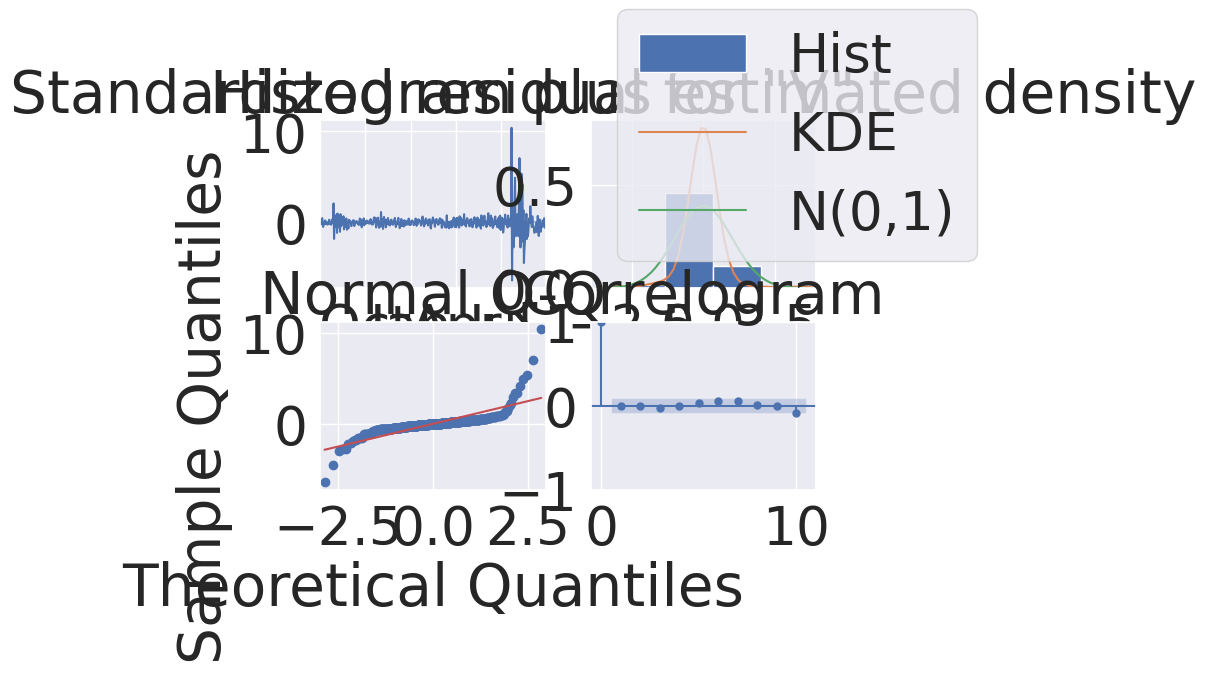

In [67]:
plt.figure(figsize=(24,4))

arima_result.plot_diagnostics()
plt.show()

In [68]:
arima_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Views   No. Observations:                  458
Model:               SARIMAX(6, 1, 5)   Log Likelihood               -1251.641
Date:                Thu, 27 Apr 2023   AIC                           2527.282
Time:                        21:06:21   BIC                           2576.778
Sample:                    07-01-2015   HQIC                          2546.777
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5174      0.248     -6.110      0.000      -2.004      -1.031
ar.L2         -0.9741      0.335     -2.906      0.004      -1.631      -0.317
ar.L3          0.0422      0.186      0.227      0.821      -0.323       0.407
ar.L4          0.5509      0.123      4.482      0.000       0.310       0.792
ar.L5          0.3131      0.187      1.675      0.094      -0.053       0.679
ar.L6         -0.0343      0.092     -0.373      0.709      -0.214       0.146
ma.L1          1.1636      0.248      4.695      0.000       0.678       1.649
ma.L2          0.2323      0.246      0.944      0.345      -0.250       0.715
ma.L3         -0.9047      0.041    -21.989      0.000      -0.985      -0.824
ma.L4         -0.8828      0.246     -3.587      0.000      -1.365      -0.401
ma.L5         -0.1535      0.196     -0.784      0.433      -0.537       0.230
sigma2        13.9182      0.238     58.457      0.000      13.452      14.385
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             27746.23
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              15.58   Skew:                             3.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

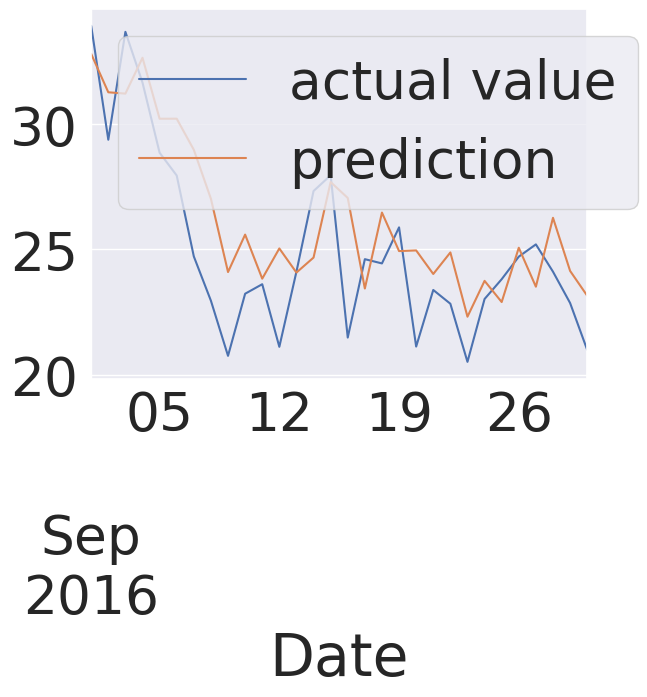

In [69]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean[-30:].plot(ax=ax,label='prediction')
plt.legend()
plt.show()

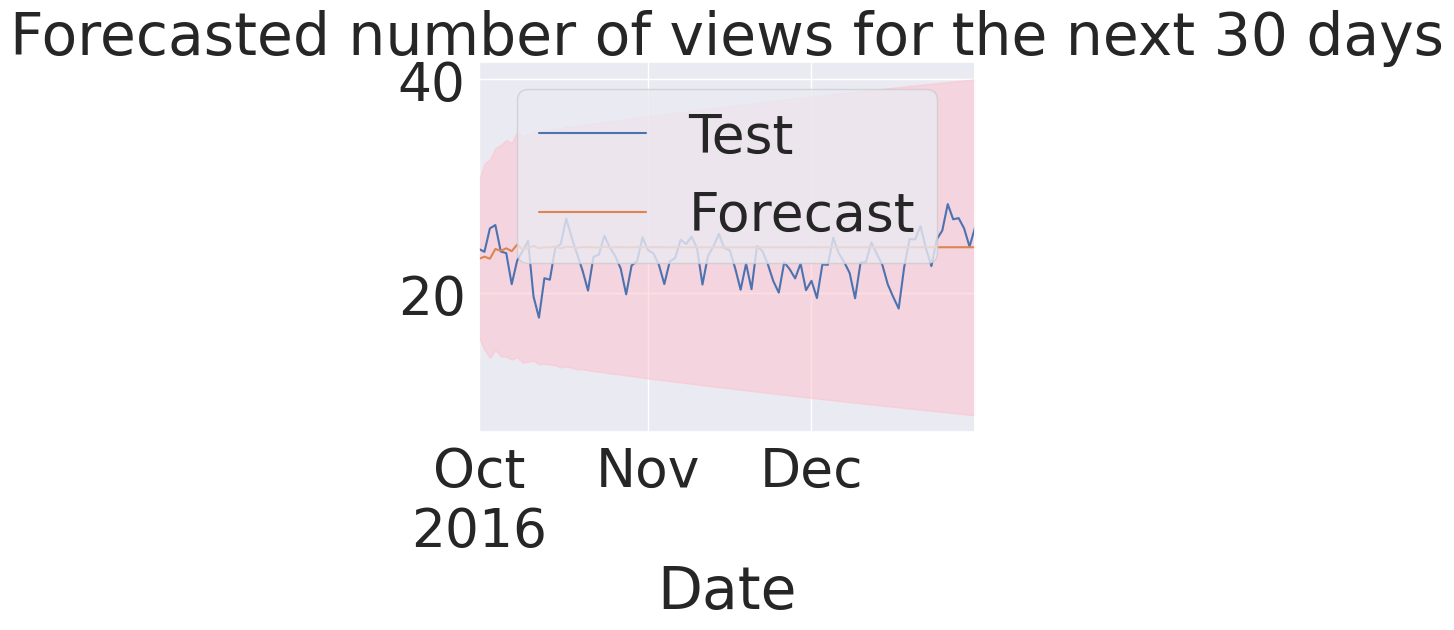

In [70]:
# Forecasting using ARIMA moidel
arima_forecast_values = arima_result.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

arima_forecast_df = pd.DataFrame({'Date':test.index,'Views':arima_forecast_values.predicted_mean,'lower_views':arima_conf_interval['lower Views'].values,'upper_views':arima_conf_interval['upper Views'].values})
arima_forecast_df = arima_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Test'}).plot(ax=ax)
arima_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax)
plt.fill_between(arima_forecast_df.index, \
                arima_forecast_df.lower_views, \
                arima_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [71]:
rmse_values.append(('ARIMA',np.sqrt(np.mean(np.square(arima_forecast_df.Views.values - test.Views.values)))))


## 6. Exponential smoothing model


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


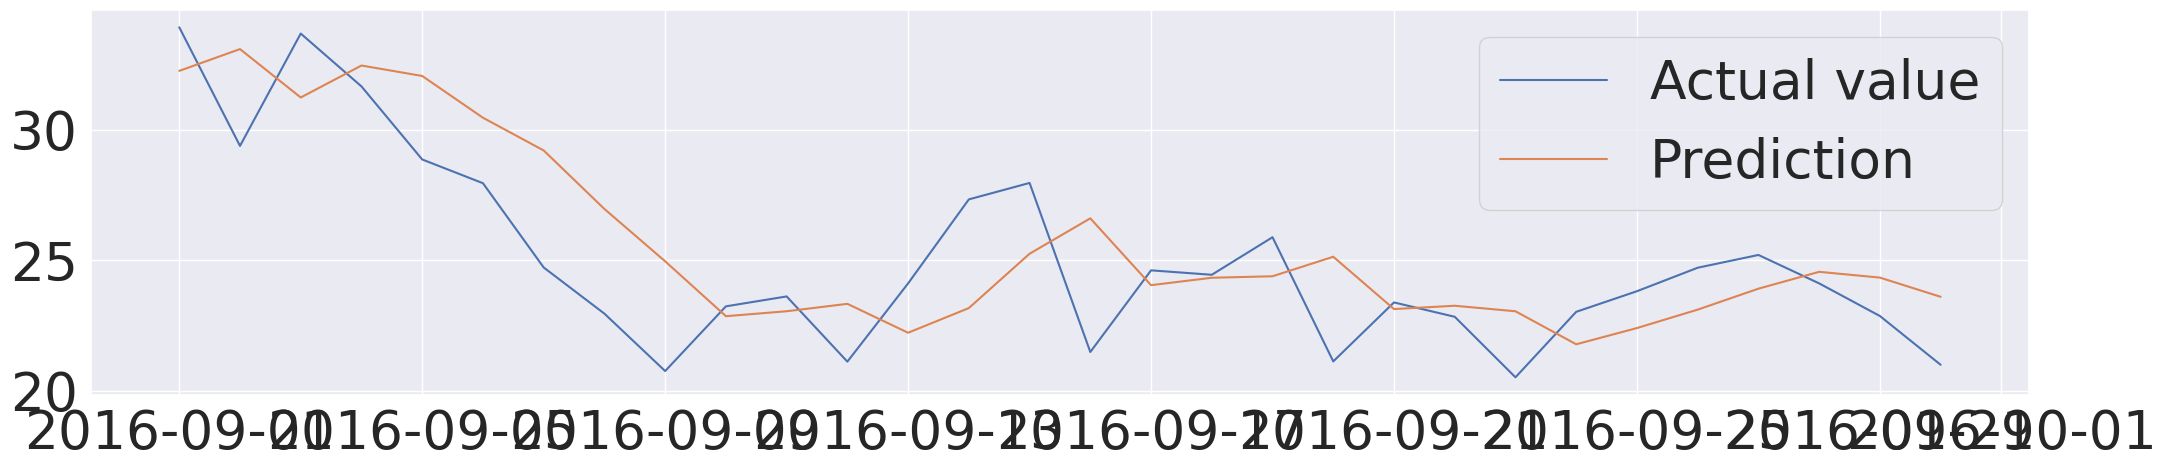

In [72]:
exp_smoothing_model = SimpleExpSmoothing(train)
exp_smoothing_result = exp_smoothing_model.fit(smoothing_level=0.5,optimized=True)

# Prediction using Exponential Smoothing model
exp_smoothing_prediction = exp_smoothing_result.predict(start=train[-30:-29].index[0],end=train[-1:].index[0])

plt.figure(figsize=(25,5))
plt.plot(train[-30:], label='Actual value')
plt.plot(exp_smoothing_prediction, label='Prediction')
plt.legend(loc='best')
plt.show()

In [73]:
with open('exp_smoothing_model.pkl', 'wb') as f:
    pickle.dump(exp_smoothing_model, f)

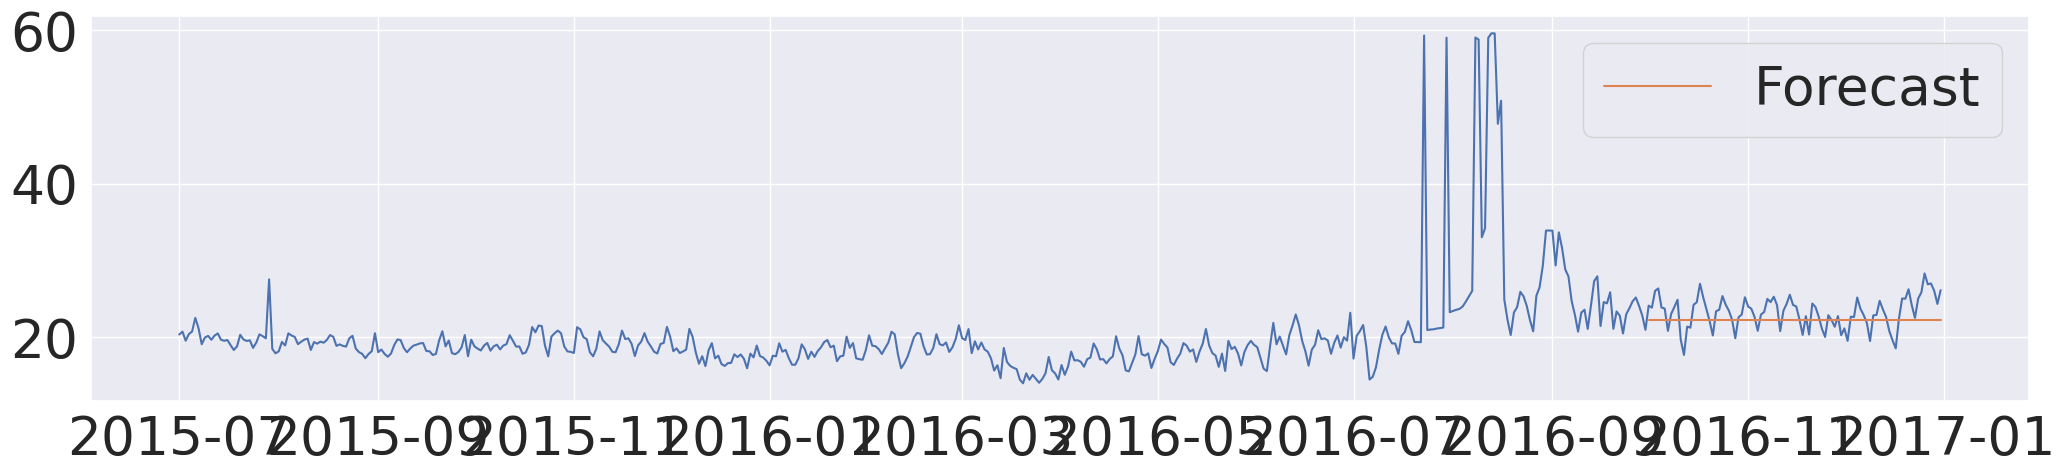

In [74]:
# Forecasting using Exponential smoothing model
exp_smoothing_forecast = exp_smoothing_result.forecast(test.shape[0])
plt.figure(figsize=(25,5))

plt.plot(top_page_df)
plt.plot(exp_smoothing_forecast, label='Forecast')
plt.legend(loc='best')
plt.show()

In [75]:
rmse_values.append(('Exponential Smoothing',np.sqrt(np.mean(np.square(exp_smoothing_forecast.values - test.Views.values)))))


## 8. Auto Arima


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2609.234, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2712.856, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2669.041, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2630.326, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2710.856, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2610.257, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2610.930, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2606.553, Time=1.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2611.231, Time=0.81 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2608.539, Time=1.68 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2608.876, Time=1.03 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2604.6

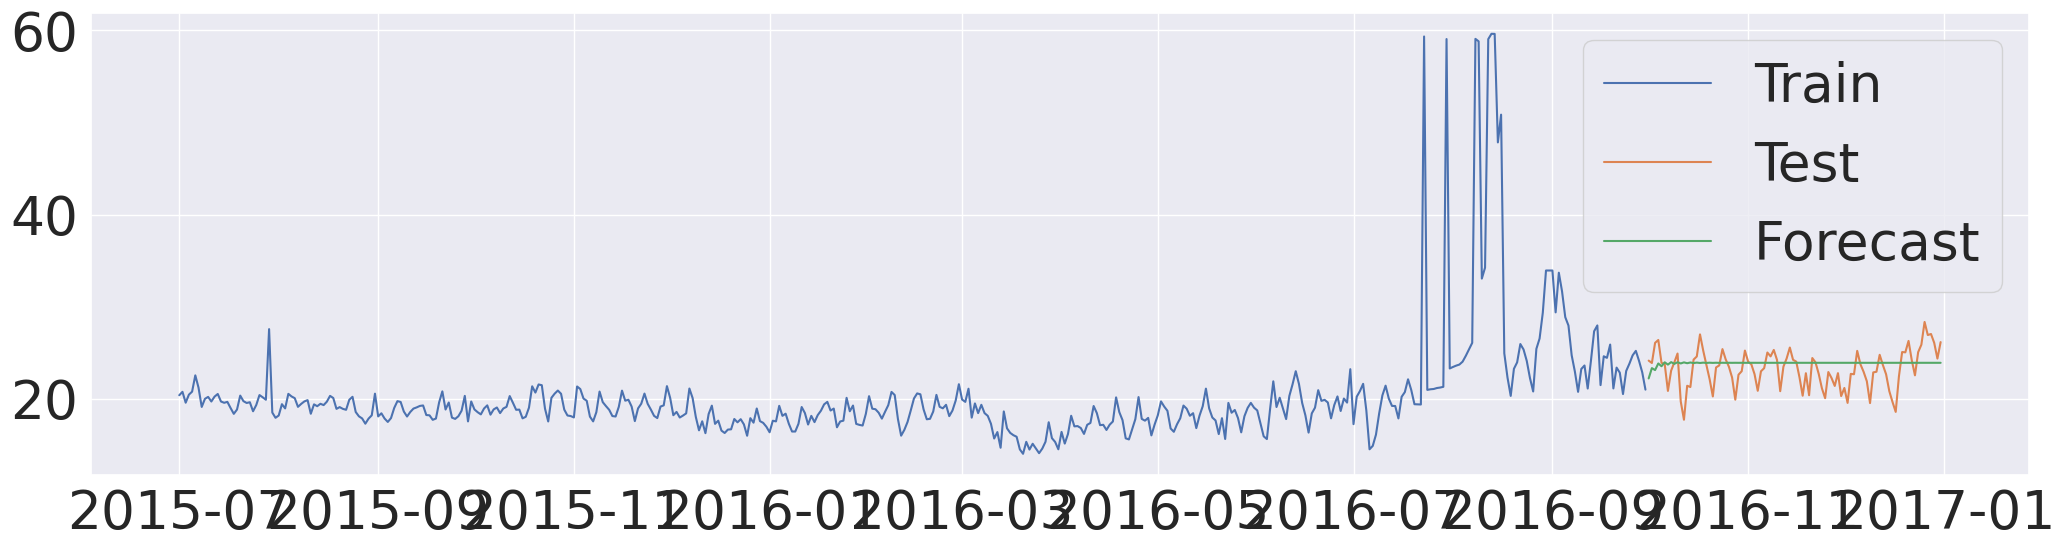

In [76]:
auto_arima_model = auto_arima(train,start_p=2,max_p=7,start_q=2,max_q=7, m=1,stationary=False,trace=True, seasonal=False,error_action='ignore',suppress_warnings=True)
auto_arima_model.fit(train)

auto_arima_forecast = auto_arima_model.predict(n_periods=test.shape[0])
auto_arima_forecast = pd.DataFrame(auto_arima_forecast,index = test.index,columns=['Forecast'])

plt.figure(figsize=(25,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(auto_arima_forecast, label='Forecast')
plt.legend()
plt.show()

In [77]:
with open('auto_arima_model.pkl', 'wb') as f:
    pickle.dump(auto_arima_model, f)

In [78]:
rmse_values.append(('Auto-arima',np.sqrt(np.mean(np.square(auto_arima_forecast.values - test.Views.values)))))


Compairing RMSE values

In [79]:
# RMSE
rmse_df = pd.DataFrame(rmse_values,columns=['Model','RMSE_values']).sort_values('RMSE_values')
rmse_df

,Model,RMSE_values
0,ARMA,2.152765
3,Auto-arima,2.167248
2,Exponential Smoothing,2.278368
1,ARIMA,2.332159


## 9. LSTMs


In [80]:
def transform_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [81]:
time_steps = 10


In [82]:
X_train, y_train = transform_dataset(train, train.Views, time_steps)
X_test, y_test = transform_dataset(test, test.Views, time_steps)

In [83]:
# Build the model
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=256,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.RMSprop()
)

In [84]:
# Training the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/200
26/26 [==============================] - 4s 46ms/step - loss: 81.6054 - val_loss: 19.5653
Epoch 2/200
26/26 [==============================] - 1s 24ms/step - loss: 38.3351 - val_loss: 19.9324
Epoch 3/200
26/26 [==============================] - 1s 23ms/step - loss: 33.7401 - val_loss: 15.2518
Epoch 4/200
26/26 [==============================] - 1s 26ms/step - loss: 32.6398 - val_loss: 13.4572
Epoch 5/200
26/26 [==============================] - 1s 23ms/step - loss: 31.1928 - val_loss: 13.5498
Epoch 6/200
26/26 [==============================] - 1s 25ms/step - loss: 30.6317 - val_loss: 14.7928
Epoch 7/200
26/26 [==============================] - 1s 23ms/step - loss: 29.4311 - val_loss: 18.1418
Epoch 8/200
26/26 [==============================] - 1s 23ms/step - loss: 28.9421 - val_loss: 22.3429
Epoch 9/200
26/26 [==============================] - 1s 24ms/step - loss: 28.0370 - val_loss: 26.6789
Epoch 10/200
26/26 [==============================] - 1s 23ms/step - loss: 27.4063

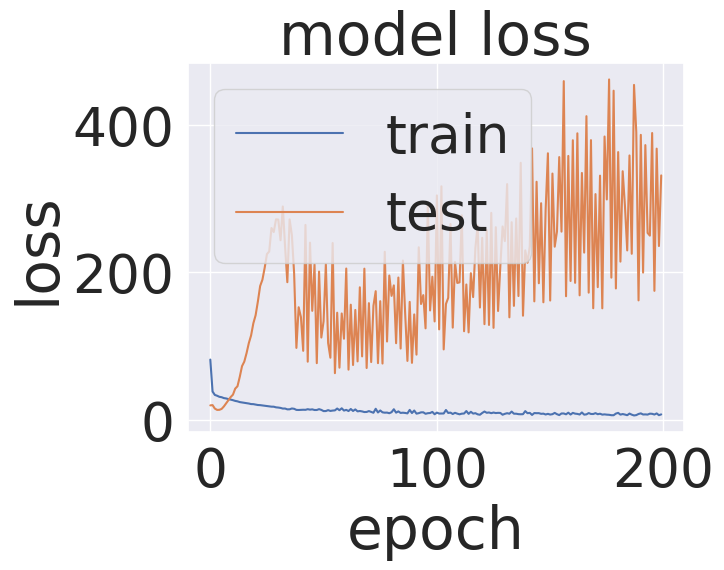

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [86]:

# Forecasting using test data
y_pred = model.predict(X_test)

3/3 [==============================] - 1s 10ms/step


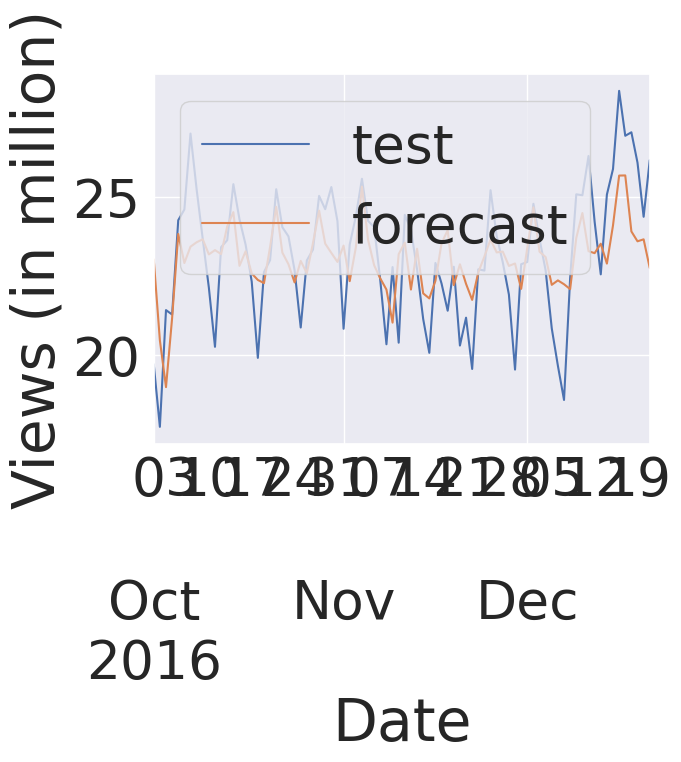

In [87]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'forecast'], loc='upper left')
plt.ylabel('Views (in million)')
plt.show()

In [88]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))


RMSE:1.6696212664695742


## 10. CNN1D


In [89]:
n_features=1
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, n_features)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [90]:
# Training the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/200
26/26 [==============================] - 1s 10ms/step - loss: 76.5986 - val_loss: 158.6112
Epoch 2/200
26/26 [==============================] - 0s 4ms/step - loss: 18.2335 - val_loss: 159.2301
Epoch 3/200
26/26 [==============================] - 0s 5ms/step - loss: 17.8080 - val_loss: 155.0561
Epoch 4/200
26/26 [==============================] - 0s 4ms/step - loss: 19.1428 - val_loss: 146.4907
Epoch 5/200
26/26 [==============================] - 0s 5ms/step - loss: 19.0046 - val_loss: 152.5491
Epoch 6/200
26/26 [==============================] - 0s 5ms/step - loss: 18.0160 - val_loss: 158.9041
Epoch 7/200
26/26 [==============================] - 0s 4ms/step - loss: 16.9458 - val_loss: 161.5675
Epoch 8/200
26/26 [==============================] - 0s 4ms/step - loss: 16.7600 - val_loss: 165.9190
Epoch 9/200
26/26 [==============================] - 0s 4ms/step - loss: 16.7285 - val_loss: 164.6913
Epoch 10/200
26/26 [==============================] - 0s 4ms/step - loss: 16.0482

In [91]:
#forecasting
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


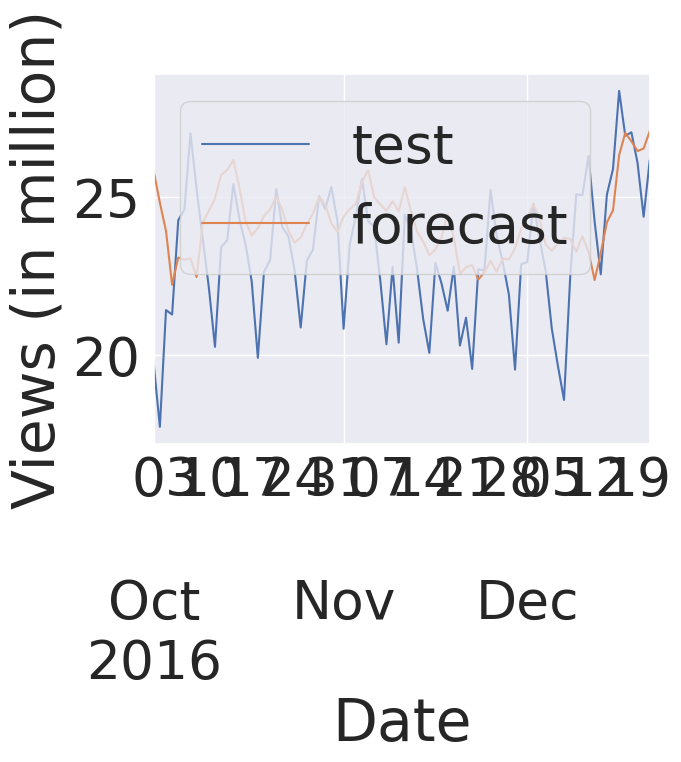

In [92]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'forecast'], loc='upper left')
plt.ylabel('Views (in million)')
plt.show()

In [93]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))


RMSE:2.2553716709463916


## Conclusion

LSTMs outperforms all approaches.

Reference - https://github.com/Suraj520/data-science/blob/main/01-machine-learning/20-web-traffic-time-series-forecast/notebook.ipynb